In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import sys
import os 
from scipy.sparse import linalg
from pathlib import Path
if torch.cuda.is_available():  
    device = "cuda" 
else:  
    device = "cpu" 


torch.set_default_dtype(torch.float64)
pi = torch.tensor(np.pi,dtype=torch.float64)

class model(nn.Module):
    """ ReLU k shallow neural network
    Parameters: 
    input size: input dimension
    hidden_size1 : number of hidden layers 
    num_classes: output classes 
    k: degree of relu functions
    """
    def __init__(self, input_size, hidden_size1, num_classes,k = 1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias = False)
        self.k = k 
    def forward(self, x):
        u1 = self.fc2(F.relu(self.fc1(x))**self.k)
        return u1


def plot_2D(f): 
    
    Nx = 400
    Ny = 400 
    xs = np.linspace(0, 1, Nx)
    ys = np.linspace(0, 1, Ny)
    x, y = np.meshgrid(xs, ys, indexing='xy')
    xy_comb = np.stack((x.flatten(),y.flatten())).T
    xy_comb = torch.tensor(xy_comb)
    z = f(xy_comb).reshape(Nx,Ny)
    z = z.detach().numpy()
    plt.figure(dpi=200)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x , y , z )

    plt.show()

def plot_subdomains(my_model):
    x_coord =torch.linspace(0,1,200)
    wi = my_model.fc1.weight.data
    bi = my_model.fc1.bias.data 
    for i, bias in enumerate(bi):  
        if wi[i,1] !=0: 
            plt.plot(x_coord, - wi[i,0]/wi[i,1]*x_coord - bias/wi[i,1])
        else: 
            plt.plot(x_coord,  - bias/wi[i,0]*torch.ones(x_coord.size()))

    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend()
    plt.show()
    return 0 

def show_convergence_order(err_l2,exponent,dict_size, filename,write2file = False):
    
    if write2file:
        file_mode = "a" if os.path.exists(filename) else "w"
        f_write = open(filename, file_mode)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]
    if write2file:
        f_write.write('dictionary size: {}\n'.format(dict_size))
        f_write.write("neuron num \t\t error \t\t order \t\t h10 error \\ order \n")
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            print("{} \t\t {:.6f} \t\t *  \n".format(neuron_nums[i],item ) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t * \t\t \n".format(neuron_nums[i],item ))
        else: 
            print("{} \t\t {:.6f} \t\t {:.6f} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2) ) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t {} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2) ))
    if write2file:     
        f_write.write("\n")
        f_write.close()

def show_convergence_order_latex(err_l2,exponent,k=1,d=1): 
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]
    l2_order = -1/2-(2*k + 1)/(2*d)
    print("neuron num  & \t $\\|u-u_n \\|_{{L^2}}$ & \t order $O(n^{{{:.2f}}})$  \\\\ \\hline \\hline ".format(l2_order))
    for i, item in enumerate(err_list):
        if i == 0: 
            print("{} \t\t & {:.6f} &\t\t *  \\\ \hline  \n".format(neuron_nums[i],item) )   
        else: 
            print("{} \t\t &  {:.3e} &  \t\t {:.2f} \\\ \hline  \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2) ) )



In [3]:
def PiecewiseGQ2D_weights_points(Nx, order): 
    """ A slight modification of PiecewiseGQ2D function that only needs the weights and integration points.
    Parameters
    ----------

    Nx: int 
        number of intervals along the dimension. No Ny, assume Nx = Ny
    order: int 
        order of the Gauss Quadrature

    Returns
    -------
    long_weights: torch.tensor
    integration_points: torch.tensor
    """
#     print("order: ",order )
    x, w = np.polynomial.legendre.leggauss(order)
    gauss_pts = np.array(np.meshgrid(x,x,indexing='ij')).reshape(2,-1).T
    weights =  (w*w[:,None]).ravel()

    gauss_pts =torch.tensor(gauss_pts)
    weights = torch.tensor(weights)

    h = 1/Nx # 100 intervals 
    long_weights =  torch.tile(weights,(Nx**2,1))
    long_weights = long_weights.reshape(-1,1)
    long_weights = long_weights * h**2 /4 

    integration_points = torch.tile(gauss_pts,(Nx**2,1))
    scale_factor = h/2 
    integration_points = scale_factor * integration_points

    index = np.arange(1,Nx+1)-0.5
    ordered_pairs = np.array(np.meshgrid(index,index,indexing='ij'))
    ordered_pairs = ordered_pairs.reshape(2,-1).T
    ordered_pairs = torch.tensor(ordered_pairs)
    ordered_pairs = torch.tile(ordered_pairs, (1,order**2)) # number of GQ points

    ordered_pairs =  ordered_pairs.reshape(-1,2)
    translation = ordered_pairs*h 

    integration_points = integration_points + translation 
    return long_weights, integration_points


def minimize_linear_layer_explicit_assemble(model,target,weights, integration_points,solver="direct"):
    """
    calls the following functions (dependency): 
    1. GQ_piecewise_2D
    input: the nn model containing parameter 
    1. define the loss function  
    2. take derivative to extract the linear system A
    3. call the cg solver in scipy to solve the linear system 
    output: sol. solution of Ax = b
    """
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    jac = weighted_basis_value_col.t() @ basis_value_col 
     
    rhs = weighted_basis_value_col.t() @ (target(integration_points)) 
    print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)
    return sol 


def OGAL2FittingReLU2D(my_model,target,N_list,num_epochs,plot_freq, Nx, order, k =1, linear_solver = "direct"): 
    """ Orthogonal greedy algorithm 2D \Omega = (0,1)^2 
    Parameters
    ----------
    my_model: 
        nn model 
    target: 
        target function
    num_epochs: int 
        number of training epochs 
    integration_intervals: int 
        number of subintervals for piecewise numerical quadrature 

    Returns
    -------
    err: tensor 
        rank 1 torch tensor to record the L2 error history  
    model: 
        trained nn model 
    """
    #Todo Done
    gw_expand, integration_points = PiecewiseGQ2D_weights_points(Nx, order)
    gw_expand = gw_expand.to(device)
    integration_points = integration_points.to(device)

    err = torch.zeros(num_epochs+1)
    if my_model == None: 
        func_values = target(integration_points)
        num_neuron = 0

        list_b = []
        list_w = []
    else: 
        func_values = target(integration_points) - my_model(integration_points).detach()
        bias = my_model.fc1.bias.detach().data
        weights = my_model.fc1.weight.detach().data
        num_neuron = int(bias.size(0))

        list_b = list(bias)
        list_w = list(weights)
    
    # initial error Todo Done
    func_values_sqrd = func_values*func_values
    # print(func_values_sqrd.size())
    # print(gw_expand.size()) 
    err[0]= torch.sum(func_values_sqrd*gw_expand)**0.5
    start_time = time.time()
    solver = linear_solver
    relu_dict_parameters = generate_relu_dict2D(N_list).to(device)
    print("using linear solver: ",solver)
    for i in range(num_epochs): 
        print("epoch: ",i+1, end = '\t')
        if num_neuron == 0: 
            func_values = target(integration_points)
        else: 
            func_values = target(integration_points) - my_model(integration_points).detach()

        weight_func_values = func_values*gw_expand  
        basis_values = (F.relu( torch.matmul(integration_points,relu_dict_parameters[:,0:2].T ) - relu_dict_parameters[:,2])**k).T # uses broadcasting

        output = torch.abs(torch.matmul(basis_values,weight_func_values)) # 
        neuron_index = torch.argmax(output.flatten())
        
        # print(neuron_index)
        list_w.append(relu_dict_parameters[neuron_index,0:2]) # 
        list_b.append(-relu_dict_parameters[neuron_index,2])
        num_neuron += 1
        my_model = model(2,num_neuron,1,k).to(device)
        w_tensor = torch.stack(list_w, 0 ) 
        b_tensor = torch.tensor(list_b)
        my_model.fc1.weight.data[:,:] = w_tensor[:,:]
        my_model.fc1.bias.data[:] = b_tensor[:]

        #Todo Done 
#         sol = minimize_linear_layer(my_model,target,solver,Nx,order)
        sol = minimize_linear_layer_explicit_assemble(my_model,target,gw_expand, integration_points, solver)

        my_model.fc2.weight.data[0,:] = sol[:]
        if (i+1)%plot_freq == 0: 
            plot_2D(my_model.cpu())
            my_model = my_model.to(device)

        func_values = target(integration_points) - my_model(integration_points).detach()
        func_values_sqrd = func_values*func_values

        #Todo Done 
        err[i+1]= torch.sum(func_values_sqrd*gw_expand)**0.5
    print("time taken: ",time.time() - start_time)
    return err, my_model


def generate_relu_dict2D(N_list):
    N1 = N_list[0] 
    N2 = N_list[1]
    
    theta = np.linspace(0, 2*pi, N1, endpoint= False).reshape(N1,1)
    W1 = np.cos(theta)
    W2 = np.sin(theta)
    W = np.concatenate((W1,W2),1) # N1 x 2
    b = np.linspace(-1.42, 1.42, N2,endpoint=False).reshape(N2,1)
    
    index1 = np.arange(N1)
    index2 = np.arange(N2)
    ordered_pairs = np.array(np.meshgrid(index1,index2,indexing='ij'))

    ordered_pairs = ordered_pairs.reshape(2,-1).T
    W = W[ordered_pairs[:,0],:]
    b = b[ordered_pairs[:,1],:]
    Wb = np.concatenate((W,b),1) # N1 x 3 
    Wb_tensor = torch.from_numpy(Wb) 
    return Wb_tensor

def generate_relu_dict2D_QMC(s,N0):
    # Generate randomized Sobol sequence 
    
#     Sob = torch.quasirandom.SobolEngine(dimension =2, scramble= True, seed=None) 
#     samples = Sob.draw(N0).double()

#     for i in range(s-1):
#         samples = torch.cat([samples,Sob.draw(N0).double()],0)

    samples = torch.rand(s*N0,2) 
    
    T =torch.tensor([[2*pi,0],[0,2.84]])

    shift = torch.tensor([0,-1.42]) 

    samples = samples@T + shift 

    theta = samples[:,0].reshape(s*N0,1)
    W1 = torch.cos(theta)
    W2 = torch.sin(theta)
    W = torch.cat((W1,W2),1) # N1 x 2
    # b = np.linspace(-1.42, 1.42, N2,endpoint=False).reshape(N2,1) 
    b = samples[:,1].reshape(s*N0,1)
    
    Wb = torch.cat((W,b),1) # N1 x 3 

    return Wb 

def OGAL2FittingReLU2D_QMC(my_model,target,s,N0,num_epochs,plot_freq, Nx, order, k =1, linear_solver = "direct"): 
    """ Orthogonal greedy algorithm using 1D ReLU dictionary over [-pi,pi]
    Parameters
    ----------
    my_model: 
        nn model 
    target: 
        target function
    num_epochs: int 
        number of training epochs 
    integration_intervals: int 
        number of subintervals for piecewise numerical quadrature 

    Returns
    -------
    err: tensor 
        rank 1 torch tensor to record the L2 error history  
    model: 
        trained nn model 
    """
    #Todo Done
    gw_expand, integration_points = PiecewiseGQ2D_weights_points(Nx, order)
    gw_expand = gw_expand.to(device)
    integration_points = integration_points.to(device)

    err = torch.zeros(num_epochs+1)
    if my_model == None: 
        func_values = target(integration_points)
        num_neuron = 0

        list_b = []
        list_w = []
    else: 
        func_values = target(integration_points) - my_model(integration_points).detach()
        bias = my_model.fc1.bias.detach().data
        weights = my_model.fc1.weight.detach().data
        num_neuron = int(bias.size(0))

        list_b = list(bias)
        list_w = list(weights)
    
    # initial error Todo Done
    func_values_sqrd = func_values*func_values
    err[0]= torch.sum(func_values_sqrd*gw_expand)**0.5
    start_time = time.time()
    
    solver = linear_solver
    print("using linear solver: ",solver)
    for i in range(num_epochs): 
        relu_dict_parameters = generate_relu_dict2D_QMC(s,N0).to(device) 
        print("epoch: ",i+1, end = '\t')
        if num_neuron == 0: 
            func_values = target(integration_points)
        else: 
            func_values = target(integration_points) - my_model(integration_points).detach()

        weight_func_values = func_values*gw_expand  
        basis_values = (F.relu( torch.matmul(integration_points,relu_dict_parameters[:,0:2].T ) - relu_dict_parameters[:,2])**k).T # uses broadcasting

        output = torch.abs(torch.matmul(basis_values,weight_func_values)) # 
        neuron_index = torch.argmax(output.flatten())
        
        # print(neuron_index)
        list_w.append(relu_dict_parameters[neuron_index,0:2]) # 
        list_b.append(-relu_dict_parameters[neuron_index,2])
        num_neuron += 1
        my_model = model(2,num_neuron,1,k).to(device)
        w_tensor = torch.stack(list_w, 0 ) 
        b_tensor = torch.tensor(list_b)
        my_model.fc1.weight.data[:,:] = w_tensor[:,:]
        my_model.fc1.bias.data[:] = b_tensor[:]

        #Todo 
#         sol = minimize_linear_layer(my_model,target,solver,Nx,order)
        sol = minimize_linear_layer_explicit_assemble(my_model,target,gw_expand, integration_points, solver)

        my_model.fc2.weight.data[0,:] = sol[:]
        if (i+1)%plot_freq == 0: 
            plot_2D(my_model.cpu())
            my_model = my_model.to(device)

        func_values = target(integration_points) - my_model(integration_points).detach()
        func_values_sqrd = func_values*func_values

        #Todo Done 
        err[i+1]= torch.sum(func_values_sqrd*gw_expand)**0.5
    print("time taken: ",time.time() - start_time)
    return err, my_model


In the following tests, we compare using deterministic dictionaries with using random dictionary for the following three target functions. 

- $\sin(\pi x_1) \sin(\pi x_2)$ 
- $\sin(4\pi x_1) \sin(8\pi x_2)$ 
- Gabor function 

## Gabor function  deterministic 

using linear solver:  ls
epoch:  1	assembling the matrix time taken:  0.0002944469451904297
solving Ax = b time taken:  0.0001590251922607422
epoch:  2	assembling the matrix time taken:  0.00029540061950683594
solving Ax = b time taken:  0.0003104209899902344
epoch:  3	assembling the matrix time taken:  0.00027489662170410156
solving Ax = b time taken:  0.00013113021850585938
epoch:  4	assembling the matrix time taken:  0.0002715587615966797
solving Ax = b time taken:  0.00012564659118652344
epoch:  5	assembling the matrix time taken:  0.0002741813659667969
solving Ax = b time taken:  0.0001277923583984375
epoch:  6	assembling the matrix time taken:  0.00027251243591308594
solving Ax = b time taken:  0.0001361370086669922
epoch:  7	assembling the matrix time taken:  0.0002720355987548828
solving Ax = b time taken:  0.00013065338134765625
epoch:  8	assembling the matrix time taken:  0.0002694129943847656
solving Ax = b time taken:  0.0001404285430908203
epoch:  9	assembling the matrix t

epoch:  113	assembling the matrix time taken:  0.0006012916564941406
solving Ax = b time taken:  0.0017123222351074219
epoch:  114	assembling the matrix time taken:  0.00030541419982910156
solving Ax = b time taken:  0.001481771469116211
epoch:  115	assembling the matrix time taken:  0.0002903938293457031
solving Ax = b time taken:  0.0015423297882080078
epoch:  116	assembling the matrix time taken:  0.0003142356872558594
solving Ax = b time taken:  0.0014905929565429688
epoch:  117	assembling the matrix time taken:  0.0002989768981933594
solving Ax = b time taken:  0.0015866756439208984
epoch:  118	assembling the matrix time taken:  0.00030732154846191406
solving Ax = b time taken:  0.001573801040649414
epoch:  119	assembling the matrix time taken:  0.00029206275939941406
solving Ax = b time taken:  0.0016319751739501953
epoch:  120	assembling the matrix time taken:  0.0003056526184082031
solving Ax = b time taken:  0.001584768295288086
epoch:  121	assembling the matrix time taken:  0

solving Ax = b time taken:  0.005325794219970703
epoch:  199	assembling the matrix time taken:  0.00029206275939941406
solving Ax = b time taken:  0.004597902297973633
epoch:  200	assembling the matrix time taken:  0.00031447410583496094
solving Ax = b time taken:  0.00478053092956543
epoch:  201	assembling the matrix time taken:  0.0002942085266113281
solving Ax = b time taken:  0.0046634674072265625
epoch:  202	assembling the matrix time taken:  0.00031256675720214844
solving Ax = b time taken:  0.004586696624755859
epoch:  203	assembling the matrix time taken:  0.00029158592224121094
solving Ax = b time taken:  0.004796743392944336
epoch:  204	assembling the matrix time taken:  0.00030517578125
solving Ax = b time taken:  0.004631996154785156
epoch:  205	assembling the matrix time taken:  0.000293731689453125
solving Ax = b time taken:  0.004924774169921875
epoch:  206	assembling the matrix time taken:  0.00030231475830078125
solving Ax = b time taken:  0.00485992431640625
epoch:  2

solving Ax = b time taken:  0.008549928665161133
epoch:  271	assembling the matrix time taken:  0.0002899169921875
solving Ax = b time taken:  0.007850885391235352
epoch:  272	assembling the matrix time taken:  0.00030350685119628906
solving Ax = b time taken:  0.00736546516418457
epoch:  273	assembling the matrix time taken:  0.0002892017364501953
solving Ax = b time taken:  0.007856607437133789
epoch:  274	assembling the matrix time taken:  0.0003006458282470703
solving Ax = b time taken:  0.007775068283081055
epoch:  275	assembling the matrix time taken:  0.0002887248992919922
solving Ax = b time taken:  0.008161306381225586
epoch:  276	assembling the matrix time taken:  0.00030517578125
solving Ax = b time taken:  0.007801532745361328
epoch:  277	assembling the matrix time taken:  0.0002906322479248047
solving Ax = b time taken:  0.0081939697265625
epoch:  278	assembling the matrix time taken:  0.0003094673156738281
solving Ax = b time taken:  0.008172273635864258
epoch:  279	assem

solving Ax = b time taken:  0.012105703353881836
epoch:  352	assembling the matrix time taken:  0.000293731689453125
solving Ax = b time taken:  0.010515213012695312
epoch:  353	assembling the matrix time taken:  0.000293731689453125
solving Ax = b time taken:  0.01107478141784668
epoch:  354	assembling the matrix time taken:  0.0002930164337158203
solving Ax = b time taken:  0.011071920394897461
epoch:  355	assembling the matrix time taken:  0.000301361083984375
solving Ax = b time taken:  0.0113067626953125
epoch:  356	assembling the matrix time taken:  0.0002918243408203125
solving Ax = b time taken:  0.010965824127197266
epoch:  357	assembling the matrix time taken:  0.00029349327087402344
solving Ax = b time taken:  0.01141047477722168
epoch:  358	assembling the matrix time taken:  0.0002923011779785156
solving Ax = b time taken:  0.011379003524780273
epoch:  359	assembling the matrix time taken:  0.00029850006103515625
solving Ax = b time taken:  0.011574745178222656
epoch:  360	

solving Ax = b time taken:  0.016184091567993164
epoch:  424	assembling the matrix time taken:  0.0003077983856201172
solving Ax = b time taken:  0.014464378356933594
epoch:  425	assembling the matrix time taken:  0.0002982616424560547
solving Ax = b time taken:  0.015644311904907227
epoch:  426	assembling the matrix time taken:  0.0003032684326171875
solving Ax = b time taken:  0.015307903289794922
epoch:  427	assembling the matrix time taken:  0.00030040740966796875
solving Ax = b time taken:  0.015709638595581055
epoch:  428	assembling the matrix time taken:  0.00030493736267089844
solving Ax = b time taken:  0.015008687973022461
epoch:  429	assembling the matrix time taken:  0.0002944469451904297
solving Ax = b time taken:  0.015822172164916992
epoch:  430	assembling the matrix time taken:  0.0003108978271484375
solving Ax = b time taken:  0.01563882827758789
epoch:  431	assembling the matrix time taken:  0.00030231475830078125
solving Ax = b time taken:  0.016832590103149414
epoch

epoch:  497	assembling the matrix time taken:  0.0003190040588378906
solving Ax = b time taken:  0.02030158042907715
epoch:  498	assembling the matrix time taken:  0.00029778480529785156
solving Ax = b time taken:  0.020052671432495117
epoch:  499	assembling the matrix time taken:  0.00029754638671875
solving Ax = b time taken:  0.020786046981811523
epoch:  500	assembling the matrix time taken:  0.00029659271240234375
solving Ax = b time taken:  0.019422531127929688
epoch:  501	assembling the matrix time taken:  0.0003037452697753906
solving Ax = b time taken:  0.020572662353515625
epoch:  502	assembling the matrix time taken:  0.00030541419982910156
solving Ax = b time taken:  0.02066326141357422
epoch:  503	assembling the matrix time taken:  0.00030684471130371094
solving Ax = b time taken:  0.0209658145904541
epoch:  504	assembling the matrix time taken:  0.0002987384796142578
solving Ax = b time taken:  0.01944756507873535
epoch:  505	assembling the matrix time taken:  0.0002977848

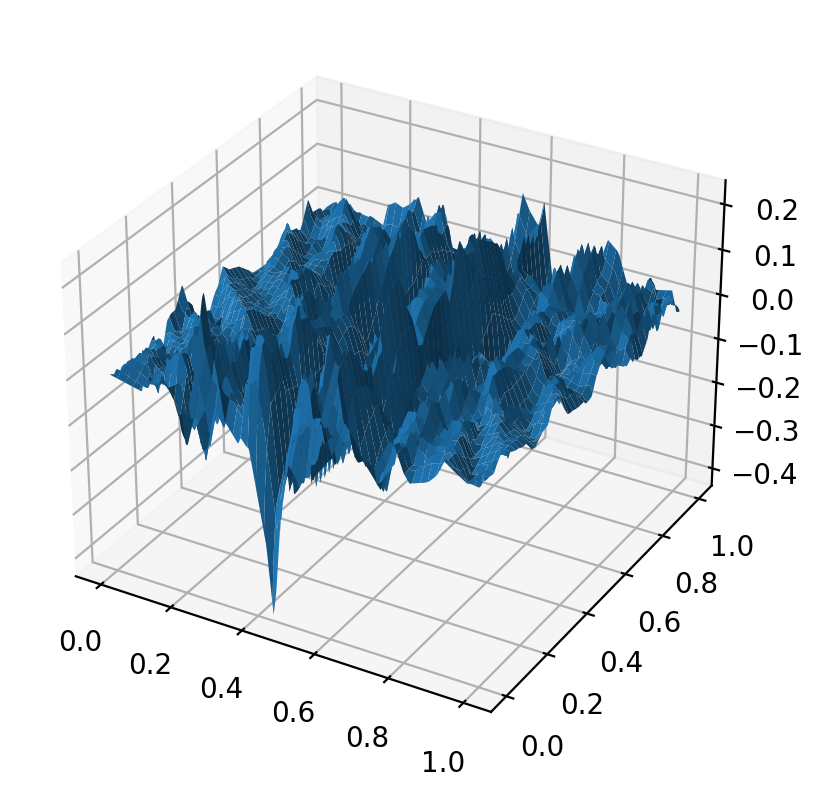

time taken:  7.265060186386108
neuron num 		 error 		 order
4 		 0.187825 		 *  

8 		 0.185880 		 0.015019 

16 		 0.185461 		 0.003254 

32 		 0.183627 		 0.014340 

64 		 0.181213 		 0.019091 

128 		 0.180351 		 0.006884 

256 		 0.180227 		 0.000989 

512 		 0.180227 		 0.000000 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order $O(n^{-1.25})$  \\ \hline \hline 
4 		 & 0.187825 &		 *  \\ \hline  

8 		 &  1.859e-01 &  		 0.02 \\ \hline  

16 		 &  1.855e-01 &  		 0.00 \\ \hline  

32 		 &  1.836e-01 &  		 0.01 \\ \hline  

64 		 &  1.812e-01 &  		 0.02 \\ \hline  

128 		 &  1.804e-01 &  		 0.01 \\ \hline  

256 		 &  1.802e-01 &  		 0.00 \\ \hline  

512 		 &  1.802e-01 &  		 0.00 \\ \hline  

using linear solver:  ls
epoch:  1	assembling the matrix time taken:  0.0002758502960205078
solving Ax = b time taken:  0.00014281272888183594
epoch:  2	assembling the matrix time taken:  0.0002713203430175781
solving Ax = b time taken:  0.00030994415283203125
epoch:  3	assembling the matrix ti

epoch:  70	assembling the matrix time taken:  0.0003094673156738281
solving Ax = b time taken:  0.0007703304290771484
epoch:  71	assembling the matrix time taken:  0.0002868175506591797
solving Ax = b time taken:  0.0007364749908447266
epoch:  72	assembling the matrix time taken:  0.0002980232238769531
solving Ax = b time taken:  0.0007166862487792969
epoch:  73	assembling the matrix time taken:  0.0002942085266113281
solving Ax = b time taken:  0.000751495361328125
epoch:  74	assembling the matrix time taken:  0.0002970695495605469
solving Ax = b time taken:  0.0007576942443847656
epoch:  75	assembling the matrix time taken:  0.0002849102020263672
solving Ax = b time taken:  0.0007889270782470703
epoch:  76	assembling the matrix time taken:  0.00029921531677246094
solving Ax = b time taken:  0.0007677078247070312
epoch:  77	assembling the matrix time taken:  0.0002834796905517578
solving Ax = b time taken:  0.0008115768432617188
epoch:  78	assembling the matrix time taken:  0.00030064

solving Ax = b time taken:  0.0030214786529541016
epoch:  151	assembling the matrix time taken:  0.0002899169921875
solving Ax = b time taken:  0.002608776092529297
epoch:  152	assembling the matrix time taken:  0.00030922889709472656
solving Ax = b time taken:  0.0024335384368896484
epoch:  153	assembling the matrix time taken:  0.0002930164337158203
solving Ax = b time taken:  0.0026519298553466797
epoch:  154	assembling the matrix time taken:  0.0003046989440917969
solving Ax = b time taken:  0.0026328563690185547
epoch:  155	assembling the matrix time taken:  0.0002980232238769531
solving Ax = b time taken:  0.002752542495727539
epoch:  156	assembling the matrix time taken:  0.00030303001403808594
solving Ax = b time taken:  0.0026509761810302734
epoch:  157	assembling the matrix time taken:  0.00029015541076660156
solving Ax = b time taken:  0.0028247833251953125
epoch:  158	assembling the matrix time taken:  0.000301361083984375
solving Ax = b time taken:  0.002789020538330078
ep

solving Ax = b time taken:  0.005765676498413086
epoch:  224	assembling the matrix time taken:  0.00031185150146484375
solving Ax = b time taken:  0.00544285774230957
epoch:  225	assembling the matrix time taken:  0.00029850006103515625
solving Ax = b time taken:  0.0057697296142578125
epoch:  226	assembling the matrix time taken:  0.0003209114074707031
solving Ax = b time taken:  0.005753755569458008
epoch:  227	assembling the matrix time taken:  0.0003044605255126953
solving Ax = b time taken:  0.005930423736572266
epoch:  228	assembling the matrix time taken:  0.0003135204315185547
solving Ax = b time taken:  0.005745410919189453
epoch:  229	assembling the matrix time taken:  0.00029850006103515625
solving Ax = b time taken:  0.006055355072021484
epoch:  230	assembling the matrix time taken:  0.0003082752227783203
solving Ax = b time taken:  0.0060346126556396484
epoch:  231	assembling the matrix time taken:  0.0002963542938232422
solving Ax = b time taken:  0.006213665008544922
epo

solving Ax = b time taken:  0.010744333267211914
epoch:  302	assembling the matrix time taken:  0.00031280517578125
solving Ax = b time taken:  0.009903192520141602
epoch:  303	assembling the matrix time taken:  0.00029754638671875
solving Ax = b time taken:  0.010178327560424805
epoch:  304	assembling the matrix time taken:  0.00030922889709472656
solving Ax = b time taken:  0.009708404541015625
epoch:  305	assembling the matrix time taken:  0.00029850006103515625
solving Ax = b time taken:  0.010205984115600586
epoch:  306	assembling the matrix time taken:  0.0003085136413574219
solving Ax = b time taken:  0.010061502456665039
epoch:  307	assembling the matrix time taken:  0.0003070831298828125
solving Ax = b time taken:  0.01046895980834961
epoch:  308	assembling the matrix time taken:  0.0003104209899902344
solving Ax = b time taken:  0.010035991668701172
epoch:  309	assembling the matrix time taken:  0.0003063678741455078
solving Ax = b time taken:  0.010498046875
epoch:  310	asse

solving Ax = b time taken:  0.016615629196166992
epoch:  378	assembling the matrix time taken:  0.0003056526184082031
solving Ax = b time taken:  0.015228271484375
epoch:  379	assembling the matrix time taken:  0.00029921531677246094
solving Ax = b time taken:  0.015591859817504883
epoch:  380	assembling the matrix time taken:  0.00029540061950683594
solving Ax = b time taken:  0.015033960342407227
epoch:  381	assembling the matrix time taken:  0.00029730796813964844
solving Ax = b time taken:  0.017667770385742188
epoch:  382	assembling the matrix time taken:  0.0002963542938232422
solving Ax = b time taken:  0.015645265579223633
epoch:  383	assembling the matrix time taken:  0.00029659271240234375
solving Ax = b time taken:  0.015996932983398438
epoch:  384	assembling the matrix time taken:  0.0002942085266113281
solving Ax = b time taken:  0.016025543212890625
epoch:  385	assembling the matrix time taken:  0.0002989768981933594
solving Ax = b time taken:  0.016231775283813477
epoch:

solving Ax = b time taken:  0.02211618423461914
epoch:  452	assembling the matrix time taken:  0.00032639503479003906
solving Ax = b time taken:  0.0209200382232666
epoch:  453	assembling the matrix time taken:  0.00029850006103515625
solving Ax = b time taken:  0.022105932235717773
epoch:  454	assembling the matrix time taken:  0.00032782554626464844
solving Ax = b time taken:  0.021853208541870117
epoch:  455	assembling the matrix time taken:  0.0003018379211425781
solving Ax = b time taken:  0.02264690399169922
epoch:  456	assembling the matrix time taken:  0.00031948089599609375
solving Ax = b time taken:  0.021198272705078125
epoch:  457	assembling the matrix time taken:  0.0003077983856201172
solving Ax = b time taken:  0.022823095321655273
epoch:  458	assembling the matrix time taken:  0.0003218650817871094
solving Ax = b time taken:  0.022050857543945312
epoch:  459	assembling the matrix time taken:  0.0003077983856201172
solving Ax = b time taken:  0.022717952728271484
epoch: 

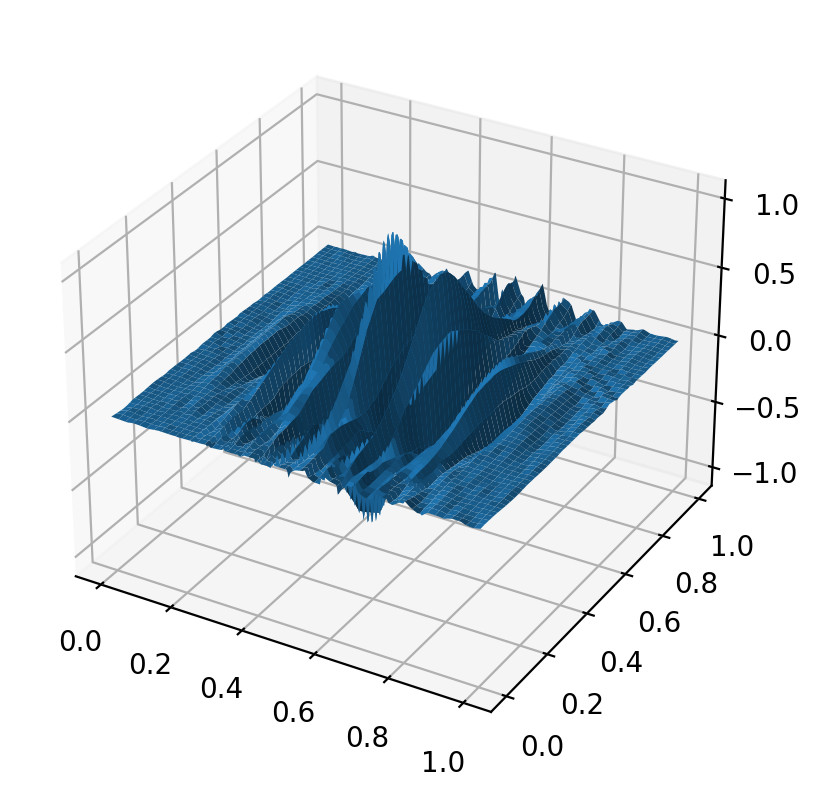

time taken:  9.39713168144226
neuron num 		 error 		 order
4 		 0.186764 		 *  

8 		 0.174292 		 0.099706 

16 		 0.137208 		 0.345145 

32 		 0.118455 		 0.212027 

64 		 0.067575 		 0.809780 

128 		 0.050245 		 0.427493 

256 		 0.049631 		 0.017753 

512 		 0.049589 		 0.001211 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order $O(n^{-1.25})$  \\ \hline \hline 
4 		 & 0.186764 &		 *  \\ \hline  

8 		 &  1.743e-01 &  		 0.10 \\ \hline  

16 		 &  1.372e-01 &  		 0.35 \\ \hline  

32 		 &  1.185e-01 &  		 0.21 \\ \hline  

64 		 &  6.757e-02 &  		 0.81 \\ \hline  

128 		 &  5.025e-02 &  		 0.43 \\ \hline  

256 		 &  4.963e-02 &  		 0.02 \\ \hline  

512 		 &  4.959e-02 &  		 0.00 \\ \hline  

using linear solver:  ls
epoch:  1	assembling the matrix time taken:  0.0002760887145996094
solving Ax = b time taken:  0.00013947486877441406
epoch:  2	assembling the matrix time taken:  0.00026917457580566406
solving Ax = b time taken:  0.00031948089599609375
epoch:  3	assembling the matrix ti

epoch:  65	assembling the matrix time taken:  0.0002970695495605469
solving Ax = b time taken:  0.0007462501525878906
epoch:  66	assembling the matrix time taken:  0.0003001689910888672
solving Ax = b time taken:  0.0006563663482666016
epoch:  67	assembling the matrix time taken:  0.0002872943878173828
solving Ax = b time taken:  0.0006852149963378906
epoch:  68	assembling the matrix time taken:  0.0003063678741455078
solving Ax = b time taken:  0.0006706714630126953
epoch:  69	assembling the matrix time taken:  0.0002853870391845703
solving Ax = b time taken:  0.0007092952728271484
epoch:  70	assembling the matrix time taken:  0.00029921531677246094
solving Ax = b time taken:  0.0007128715515136719
epoch:  71	assembling the matrix time taken:  0.0002827644348144531
solving Ax = b time taken:  0.0007462501525878906
epoch:  72	assembling the matrix time taken:  0.0002987384796142578
solving Ax = b time taken:  0.0007288455963134766
epoch:  73	assembling the matrix time taken:  0.0002856

epoch:  143	assembling the matrix time taken:  0.0005095005035400391
solving Ax = b time taken:  0.002666473388671875
epoch:  144	assembling the matrix time taken:  0.0005404949188232422
solving Ax = b time taken:  0.002463102340698242
epoch:  145	assembling the matrix time taken:  0.00045299530029296875
solving Ax = b time taken:  0.0026335716247558594
epoch:  146	assembling the matrix time taken:  0.00035953521728515625
solving Ax = b time taken:  0.0024683475494384766
epoch:  147	assembling the matrix time taken:  0.0002982616424560547
solving Ax = b time taken:  0.002599477767944336
epoch:  148	assembling the matrix time taken:  0.0010077953338623047
solving Ax = b time taken:  0.0026073455810546875
epoch:  149	assembling the matrix time taken:  0.0002970695495605469
solving Ax = b time taken:  0.0026895999908447266
epoch:  150	assembling the matrix time taken:  0.00031065940856933594
solving Ax = b time taken:  0.0026428699493408203
epoch:  151	assembling the matrix time taken:  0

epoch:  218	assembling the matrix time taken:  0.00031948089599609375
solving Ax = b time taken:  0.00540924072265625
epoch:  219	assembling the matrix time taken:  0.0002982616424560547
solving Ax = b time taken:  0.005648612976074219
epoch:  220	assembling the matrix time taken:  0.0008192062377929688
solving Ax = b time taken:  0.006556272506713867
epoch:  221	assembling the matrix time taken:  0.0002999305725097656
solving Ax = b time taken:  0.005705595016479492
epoch:  222	assembling the matrix time taken:  0.00031113624572753906
solving Ax = b time taken:  0.005709171295166016
epoch:  223	assembling the matrix time taken:  0.0002925395965576172
solving Ax = b time taken:  0.00588226318359375
epoch:  224	assembling the matrix time taken:  0.00030922889709472656
solving Ax = b time taken:  0.005519866943359375
epoch:  225	assembling the matrix time taken:  0.0003104209899902344
solving Ax = b time taken:  0.005889892578125
epoch:  226	assembling the matrix time taken:  0.000329017

solving Ax = b time taken:  0.011467456817626953
epoch:  291	assembling the matrix time taken:  0.0003135204315185547
solving Ax = b time taken:  0.009785175323486328
epoch:  292	assembling the matrix time taken:  0.0006103515625
solving Ax = b time taken:  0.009860038757324219
epoch:  293	assembling the matrix time taken:  0.0005090236663818359
solving Ax = b time taken:  0.010087013244628906
epoch:  294	assembling the matrix time taken:  0.0005121231079101562
solving Ax = b time taken:  0.010039329528808594
epoch:  295	assembling the matrix time taken:  0.0004782676696777344
solving Ax = b time taken:  0.010416030883789062
epoch:  296	assembling the matrix time taken:  0.0005259513854980469
solving Ax = b time taken:  0.009970903396606445
epoch:  297	assembling the matrix time taken:  0.0004794597625732422
solving Ax = b time taken:  0.011056900024414062
epoch:  298	assembling the matrix time taken:  0.00041365623474121094
solving Ax = b time taken:  0.01042795181274414
epoch:  299	a

solving Ax = b time taken:  0.014948844909667969
epoch:  364	assembling the matrix time taken:  0.00030493736267089844
solving Ax = b time taken:  0.014452219009399414
epoch:  365	assembling the matrix time taken:  0.0002963542938232422
solving Ax = b time taken:  0.015041112899780273
epoch:  366	assembling the matrix time taken:  0.00030159950256347656
solving Ax = b time taken:  0.014857769012451172
epoch:  367	assembling the matrix time taken:  0.00030517578125
solving Ax = b time taken:  0.015414953231811523
epoch:  368	assembling the matrix time taken:  0.0003006458282470703
solving Ax = b time taken:  0.01655292510986328
epoch:  369	assembling the matrix time taken:  0.0002963542938232422
solving Ax = b time taken:  0.016112565994262695
epoch:  370	assembling the matrix time taken:  0.0002956390380859375
solving Ax = b time taken:  0.015338659286499023
epoch:  371	assembling the matrix time taken:  0.00029921531677246094
solving Ax = b time taken:  0.015615224838256836
epoch:  37

solving Ax = b time taken:  0.020987272262573242
epoch:  436	assembling the matrix time taken:  0.0003132820129394531
solving Ax = b time taken:  0.020198583602905273
epoch:  437	assembling the matrix time taken:  0.0003070831298828125
solving Ax = b time taken:  0.020931482315063477
epoch:  438	assembling the matrix time taken:  0.0003230571746826172
solving Ax = b time taken:  0.020908117294311523
epoch:  439	assembling the matrix time taken:  0.0003025531768798828
solving Ax = b time taken:  0.021524429321289062
epoch:  440	assembling the matrix time taken:  0.00031638145446777344
solving Ax = b time taken:  0.020412683486938477
epoch:  441	assembling the matrix time taken:  0.00030875205993652344
solving Ax = b time taken:  0.02177119255065918
epoch:  442	assembling the matrix time taken:  0.00031280517578125
solving Ax = b time taken:  0.021199703216552734
epoch:  443	assembling the matrix time taken:  0.0003147125244140625
solving Ax = b time taken:  0.021775007247924805
epoch:  

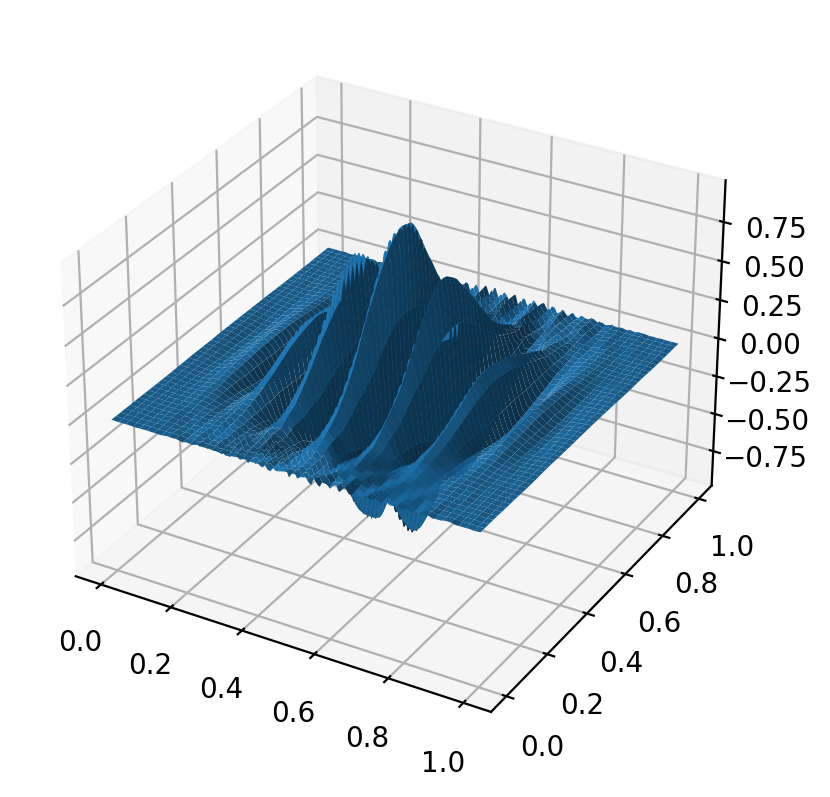

time taken:  15.106106519699097
neuron num 		 error 		 order
4 		 0.185932 		 *  

8 		 0.162812 		 0.191571 

16 		 0.152413 		 0.095217 

32 		 0.123635 		 0.301905 

64 		 0.068852 		 0.844516 

128 		 0.024712 		 1.478287 

256 		 0.010779 		 1.197002 

512 		 0.006666 		 0.693389 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order $O(n^{-1.25})$  \\ \hline \hline 
4 		 & 0.185932 &		 *  \\ \hline  

8 		 &  1.628e-01 &  		 0.19 \\ \hline  

16 		 &  1.524e-01 &  		 0.10 \\ \hline  

32 		 &  1.236e-01 &  		 0.30 \\ \hline  

64 		 &  6.885e-02 &  		 0.84 \\ \hline  

128 		 &  2.471e-02 &  		 1.48 \\ \hline  

256 		 &  1.078e-02 &  		 1.20 \\ \hline  

512 		 &  6.666e-03 &  		 0.69 \\ \hline  



In [12]:
def target(x):
    sigma = 0.15# s.d of Gaussian 
    frequency = 8  # frequency of cosine 
    z=  torch.exp( - ( (x[:,0:1]-0.5)**2 + ( x[:,1:2] -0.5)**2)  / (2*sigma**2)) *  torch.cos(2 * pi * frequency * x[:,0:1])
    return z 
dim = 2 
function_name = "gabor2d" 
filename_write = "data/2DOGA-{}-order.txt".format(function_name)
Nx = 50
order = 3
f_write = open(filename_write, "a")
f_write.write("Integration points: Nx {}, order {} \n".format(Nx,order))
f_write.close() 
save = True 
write2file = True

for N_list in [[2**5,2**5],[2**6,2**6],[2**7,2**7]]: 
    f_write = open(filename_write, "a")
    my_model = None 
    exponent = 9  
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
    relu_k = 1 
    N = np.prod(N_list)
    err_QMC2, my_model = OGAL2FittingReLU2D(my_model,target,N_list,num_epochs,plot_freq, Nx, order, k =1, linear_solver = "ls")
    
    if save: 
        folder = 'data/'
        filename = folder + 'err_OGA_2D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_OGA_2D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)

    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_QMC2[i] for i in neuron_nums ]
    show_convergence_order(err_QMC2,exponent,N,filename_write,write2file = write2file)
    show_convergence_order_latex(err_QMC2,exponent,k=relu_k,d=dim)
    



In [ ]:
## 

using linear solver:  direct
epoch:  1	assembling the matrix time taken:  0.0002892017364501953
solving Ax = b time taken:  0.00021338462829589844
epoch:  2	assembling the matrix time taken:  0.0002887248992919922
solving Ax = b time taken:  0.0002541542053222656
epoch:  3	assembling the matrix time taken:  0.00027108192443847656
solving Ax = b time taken:  0.00012946128845214844
epoch:  4	assembling the matrix time taken:  0.0002727508544921875
solving Ax = b time taken:  0.00012230873107910156
epoch:  5	assembling the matrix time taken:  0.00027298927307128906
solving Ax = b time taken:  0.00013113021850585938
epoch:  6	assembling the matrix time taken:  0.00028252601623535156
solving Ax = b time taken:  0.00012254714965820312
epoch:  7	assembling the matrix time taken:  0.00026988983154296875
solving Ax = b time taken:  0.0001285076141357422
epoch:  8	assembling the matrix time taken:  0.0002713203430175781
solving Ax = b time taken:  0.00013136863708496094
epoch:  9	assembling the 

solving Ax = b time taken:  0.0005099773406982422
epoch:  95	assembling the matrix time taken:  0.0009028911590576172
solving Ax = b time taken:  0.0006604194641113281
epoch:  96	assembling the matrix time taken:  0.0003044605255126953
solving Ax = b time taken:  0.0005102157592773438
epoch:  97	assembling the matrix time taken:  0.00029349327087402344
solving Ax = b time taken:  0.0005497932434082031
epoch:  98	assembling the matrix time taken:  0.00030875205993652344
solving Ax = b time taken:  0.0005462169647216797
epoch:  99	assembling the matrix time taken:  0.00028777122497558594
solving Ax = b time taken:  0.0005526542663574219
epoch:  100	assembling the matrix time taken:  0.00030422210693359375
solving Ax = b time taken:  0.0005533695220947266
epoch:  101	assembling the matrix time taken:  0.0002894401550292969
solving Ax = b time taken:  0.0005631446838378906
epoch:  102	assembling the matrix time taken:  0.0003077983856201172
solving Ax = b time taken:  0.0005619525909423828

epoch:  192	assembling the matrix time taken:  0.00031113624572753906
solving Ax = b time taken:  0.0009183883666992188
epoch:  193	assembling the matrix time taken:  0.00028967857360839844
solving Ax = b time taken:  0.0010061264038085938
epoch:  194	assembling the matrix time taken:  0.0002989768981933594
solving Ax = b time taken:  0.0010149478912353516
epoch:  195	assembling the matrix time taken:  0.0002880096435546875
solving Ax = b time taken:  0.0010199546813964844
epoch:  196	assembling the matrix time taken:  0.0003044605255126953
solving Ax = b time taken:  0.0009958744049072266
epoch:  197	assembling the matrix time taken:  0.00029206275939941406
solving Ax = b time taken:  0.0010313987731933594
epoch:  198	assembling the matrix time taken:  0.0003108978271484375
solving Ax = b time taken:  0.0010123252868652344
epoch:  199	assembling the matrix time taken:  0.0002980232238769531
solving Ax = b time taken:  0.0010199546813964844
epoch:  200	assembling the matrix time taken:

epoch:  267	assembling the matrix time taken:  0.00029540061950683594
solving Ax = b time taken:  0.0017042160034179688
epoch:  268	assembling the matrix time taken:  0.00030040740966796875
solving Ax = b time taken:  0.0016932487487792969
epoch:  269	assembling the matrix time taken:  0.00029969215393066406
solving Ax = b time taken:  0.0017254352569580078
epoch:  270	assembling the matrix time taken:  0.0003032684326171875
solving Ax = b time taken:  0.0017349720001220703
epoch:  271	assembling the matrix time taken:  0.0002887248992919922
solving Ax = b time taken:  0.0017666816711425781
epoch:  272	assembling the matrix time taken:  0.0003094673156738281
solving Ax = b time taken:  0.0016679763793945312
epoch:  273	assembling the matrix time taken:  0.0002944469451904297
solving Ax = b time taken:  0.0017540454864501953
epoch:  274	assembling the matrix time taken:  0.00030159950256347656
solving Ax = b time taken:  0.001756906509399414
epoch:  275	assembling the matrix time taken:

epoch:  353	assembling the matrix time taken:  0.00029587745666503906
solving Ax = b time taken:  0.0022497177124023438
epoch:  354	assembling the matrix time taken:  0.0002923011779785156
solving Ax = b time taken:  0.002277851104736328
epoch:  355	assembling the matrix time taken:  0.0002918243408203125
solving Ax = b time taken:  0.002270936965942383
epoch:  356	assembling the matrix time taken:  0.0002987384796142578
solving Ax = b time taken:  0.002277851104736328
epoch:  357	assembling the matrix time taken:  0.00029015541076660156
solving Ax = b time taken:  0.0022878646850585938
epoch:  358	assembling the matrix time taken:  0.0002899169921875
solving Ax = b time taken:  0.002286672592163086
epoch:  359	assembling the matrix time taken:  0.0002956390380859375
solving Ax = b time taken:  0.002301454544067383
epoch:  360	assembling the matrix time taken:  0.00028967857360839844
solving Ax = b time taken:  0.00229644775390625
epoch:  361	assembling the matrix time taken:  0.000292

solving Ax = b time taken:  0.002840757369995117
epoch:  425	assembling the matrix time taken:  0.0003006458282470703
solving Ax = b time taken:  0.002933025360107422
epoch:  426	assembling the matrix time taken:  0.0003039836883544922
solving Ax = b time taken:  0.0028853416442871094
epoch:  427	assembling the matrix time taken:  0.00029397010803222656
solving Ax = b time taken:  0.0029382705688476562
epoch:  428	assembling the matrix time taken:  0.00030541419982910156
solving Ax = b time taken:  0.0028600692749023438
epoch:  429	assembling the matrix time taken:  0.00029277801513671875
solving Ax = b time taken:  0.0029397010803222656
epoch:  430	assembling the matrix time taken:  0.00031256675720214844
solving Ax = b time taken:  0.0028848648071289062
epoch:  431	assembling the matrix time taken:  0.0002961158752441406
solving Ax = b time taken:  0.0029420852661132812
epoch:  432	assembling the matrix time taken:  0.0003039836883544922
solving Ax = b time taken:  0.00286865234375
e

epoch:  505	assembling the matrix time taken:  0.00029397010803222656
solving Ax = b time taken:  0.0035126209259033203
epoch:  506	assembling the matrix time taken:  0.0002956390380859375
solving Ax = b time taken:  0.003510713577270508
epoch:  507	assembling the matrix time taken:  0.0003018379211425781
solving Ax = b time taken:  0.003520965576171875
epoch:  508	assembling the matrix time taken:  0.00029349327087402344
solving Ax = b time taken:  0.003519296646118164
epoch:  509	assembling the matrix time taken:  0.00029349327087402344
solving Ax = b time taken:  0.003528118133544922
epoch:  510	assembling the matrix time taken:  0.0002930164337158203
solving Ax = b time taken:  0.003535032272338867
epoch:  511	assembling the matrix time taken:  0.00029206275939941406
solving Ax = b time taken:  0.003531932830810547
epoch:  512	assembling the matrix time taken:  0.00028824806213378906
solving Ax = b time taken:  0.0034508705139160156


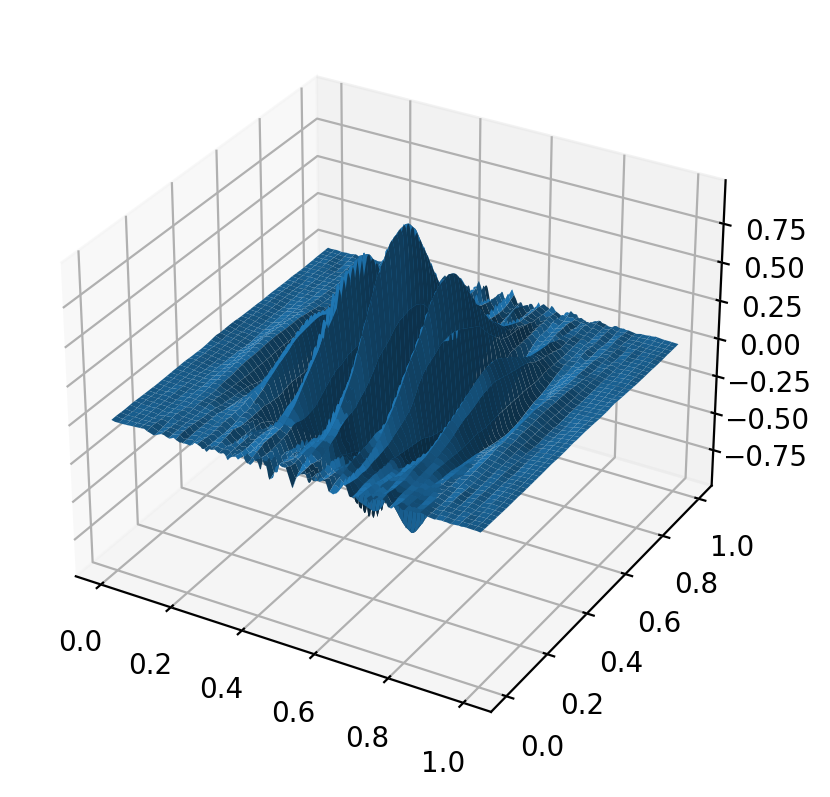

time taken:  3.7664239406585693
neuron num 		 error 		 order
4 		 0.187996 		 *  

8 		 0.187906 		 0.000692 

16 		 0.184948 		 0.022890 

32 		 0.143649 		 0.364573 

64 		 0.101660 		 0.498794 

128 		 0.054286 		 0.905104 

256 		 0.024020 		 1.176361 

512 		 0.010465 		 1.198573 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order $O(n^{-1.25})$  \\ \hline \hline 
4 		 & 0.187996 &		 *  \\ \hline  

8 		 &  1.879e-01 &  		 0.00 \\ \hline  

16 		 &  1.849e-01 &  		 0.02 \\ \hline  

32 		 &  1.436e-01 &  		 0.36 \\ \hline  

64 		 &  1.017e-01 &  		 0.50 \\ \hline  

128 		 &  5.429e-02 &  		 0.91 \\ \hline  

256 		 &  2.402e-02 &  		 1.18 \\ \hline  

512 		 &  1.047e-02 &  		 1.20 \\ \hline  

using linear solver:  direct
epoch:  1	assembling the matrix time taken:  0.0002796649932861328
solving Ax = b time taken:  0.00016832351684570312
epoch:  2	assembling the matrix time taken:  0.00026535987854003906
solving Ax = b time taken:  0.000194549560546875
epoch:  3	assembling the matri

epoch:  83	assembling the matrix time taken:  0.0002875328063964844
solving Ax = b time taken:  0.00041675567626953125
epoch:  84	assembling the matrix time taken:  0.000293731689453125
solving Ax = b time taken:  0.0004029273986816406
epoch:  85	assembling the matrix time taken:  0.00028204917907714844
solving Ax = b time taken:  0.00040912628173828125
epoch:  86	assembling the matrix time taken:  0.0002968311309814453
solving Ax = b time taken:  0.00041174888610839844
epoch:  87	assembling the matrix time taken:  0.0002810955047607422
solving Ax = b time taken:  0.00041031837463378906
epoch:  88	assembling the matrix time taken:  0.00029397010803222656
solving Ax = b time taken:  0.00040984153747558594
epoch:  89	assembling the matrix time taken:  0.0002849102020263672
solving Ax = b time taken:  0.0004177093505859375
epoch:  90	assembling the matrix time taken:  0.00029397010803222656
solving Ax = b time taken:  0.0004315376281738281
epoch:  91	assembling the matrix time taken:  0.0

solving Ax = b time taken:  0.0013968944549560547
epoch:  187	assembling the matrix time taken:  0.0002949237823486328
solving Ax = b time taken:  0.0009424686431884766
epoch:  188	assembling the matrix time taken:  0.00030422210693359375
solving Ax = b time taken:  0.0009353160858154297
epoch:  189	assembling the matrix time taken:  0.0002906322479248047
solving Ax = b time taken:  0.0009524822235107422
epoch:  190	assembling the matrix time taken:  0.0003142356872558594
solving Ax = b time taken:  0.0009386539459228516
epoch:  191	assembling the matrix time taken:  0.0003001689910888672
solving Ax = b time taken:  0.0009431838989257812
epoch:  192	assembling the matrix time taken:  0.00031113624572753906
solving Ax = b time taken:  0.0009036064147949219
epoch:  193	assembling the matrix time taken:  0.00029087066650390625
solving Ax = b time taken:  0.0010151863098144531
epoch:  194	assembling the matrix time taken:  0.00030040740966796875
solving Ax = b time taken:  0.00100636482238

epoch:  261	assembling the matrix time taken:  0.00030732154846191406
solving Ax = b time taken:  0.0015249252319335938
epoch:  262	assembling the matrix time taken:  0.0003025531768798828
solving Ax = b time taken:  0.0016493797302246094
epoch:  263	assembling the matrix time taken:  0.00028705596923828125
solving Ax = b time taken:  0.0016510486602783203
epoch:  264	assembling the matrix time taken:  0.00030231475830078125
solving Ax = b time taken:  0.00162506103515625
epoch:  265	assembling the matrix time taken:  0.0002989768981933594
solving Ax = b time taken:  0.0016696453094482422
epoch:  266	assembling the matrix time taken:  0.00030517578125
solving Ax = b time taken:  0.0016908645629882812
epoch:  267	assembling the matrix time taken:  0.00028896331787109375
solving Ax = b time taken:  0.0017077922821044922
epoch:  268	assembling the matrix time taken:  0.0003018379211425781
solving Ax = b time taken:  0.001692056655883789
epoch:  269	assembling the matrix time taken:  0.000

epoch:  348	assembling the matrix time taken:  0.0003216266632080078
solving Ax = b time taken:  0.0021021366119384766
epoch:  349	assembling the matrix time taken:  0.0002913475036621094
solving Ax = b time taken:  0.0022335052490234375
epoch:  350	assembling the matrix time taken:  0.00030732154846191406
solving Ax = b time taken:  0.0022389888763427734
epoch:  351	assembling the matrix time taken:  0.0002911090850830078
solving Ax = b time taken:  0.0022323131561279297
epoch:  352	assembling the matrix time taken:  0.0002970695495605469
solving Ax = b time taken:  0.002231597900390625
epoch:  353	assembling the matrix time taken:  0.0002963542938232422
solving Ax = b time taken:  0.002279996871948242
epoch:  354	assembling the matrix time taken:  0.0006840229034423828
solving Ax = b time taken:  0.0019757747650146484
epoch:  355	assembling the matrix time taken:  0.00029969215393066406
solving Ax = b time taken:  0.0022783279418945312
epoch:  356	assembling the matrix time taken:  0

solving Ax = b time taken:  0.002892732620239258
epoch:  420	assembling the matrix time taken:  0.00030803680419921875
solving Ax = b time taken:  0.0028252601623535156
epoch:  421	assembling the matrix time taken:  0.0002968311309814453
solving Ax = b time taken:  0.0029006004333496094
epoch:  422	assembling the matrix time taken:  0.00031280517578125
solving Ax = b time taken:  0.002846240997314453
epoch:  423	assembling the matrix time taken:  0.0002963542938232422
solving Ax = b time taken:  0.002910614013671875
epoch:  424	assembling the matrix time taken:  0.0003063678741455078
solving Ax = b time taken:  0.002836465835571289
epoch:  425	assembling the matrix time taken:  0.0003044605255126953
solving Ax = b time taken:  0.002916574478149414
epoch:  426	assembling the matrix time taken:  0.0003039836883544922
solving Ax = b time taken:  0.0028836727142333984
epoch:  427	assembling the matrix time taken:  0.0002963542938232422
solving Ax = b time taken:  0.0029332637786865234
epoc

epoch:  500	assembling the matrix time taken:  0.00031256675720214844
solving Ax = b time taken:  0.0033156871795654297
epoch:  501	assembling the matrix time taken:  0.0003018379211425781
solving Ax = b time taken:  0.0035085678100585938
epoch:  502	assembling the matrix time taken:  0.00029969215393066406
solving Ax = b time taken:  0.0035016536712646484
epoch:  503	assembling the matrix time taken:  0.0003058910369873047
solving Ax = b time taken:  0.0035102367401123047
epoch:  504	assembling the matrix time taken:  0.0003077983856201172
solving Ax = b time taken:  0.003468751907348633
epoch:  505	assembling the matrix time taken:  0.0003097057342529297
solving Ax = b time taken:  0.003514528274536133
epoch:  506	assembling the matrix time taken:  0.00030803680419921875
solving Ax = b time taken:  0.0035102367401123047
epoch:  507	assembling the matrix time taken:  0.0003185272216796875
solving Ax = b time taken:  0.0035037994384765625
epoch:  508	assembling the matrix time taken:  

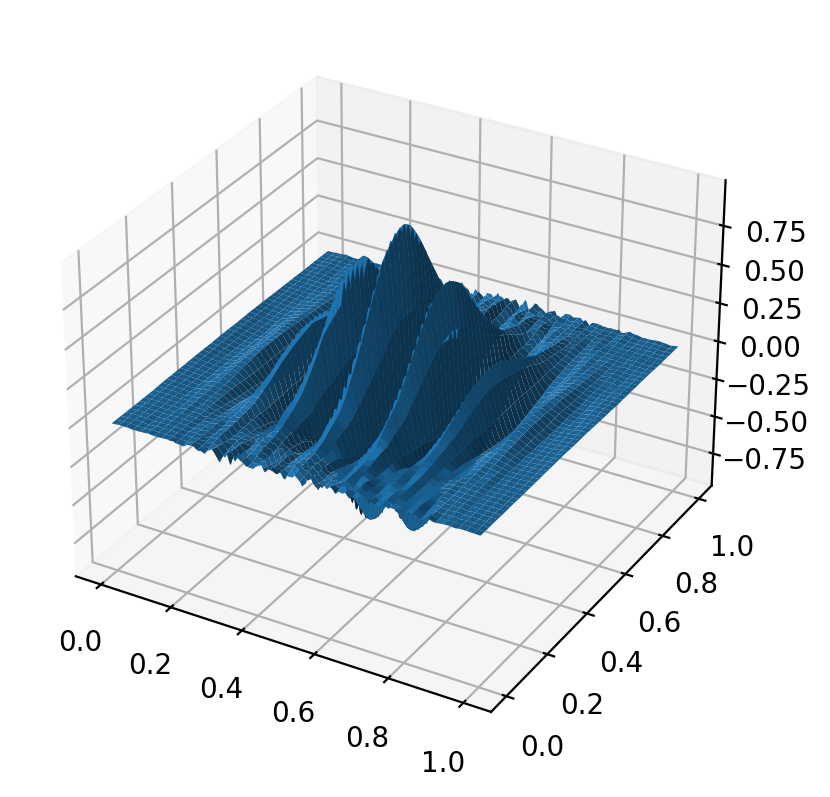

time taken:  3.6444485187530518
neuron num 		 error 		 order
4 		 0.187993 		 *  

8 		 0.187679 		 0.002419 

16 		 0.174847 		 0.102170 

32 		 0.146400 		 0.256176 

64 		 0.095915 		 0.610087 

128 		 0.047753 		 1.006173 

256 		 0.016572 		 1.526856 

512 		 0.006368 		 1.379789 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order $O(n^{-1.25})$  \\ \hline \hline 
4 		 & 0.187993 &		 *  \\ \hline  

8 		 &  1.877e-01 &  		 0.00 \\ \hline  

16 		 &  1.748e-01 &  		 0.10 \\ \hline  

32 		 &  1.464e-01 &  		 0.26 \\ \hline  

64 		 &  9.592e-02 &  		 0.61 \\ \hline  

128 		 &  4.775e-02 &  		 1.01 \\ \hline  

256 		 &  1.657e-02 &  		 1.53 \\ \hline  

512 		 &  6.368e-03 &  		 1.38 \\ \hline  

using linear solver:  direct
epoch:  1	assembling the matrix time taken:  0.00029015541076660156
solving Ax = b time taken:  0.00018024444580078125
epoch:  2	assembling the matrix time taken:  0.0002694129943847656
solving Ax = b time taken:  0.00019073486328125
epoch:  3	assembling the matrix

epoch:  79	assembling the matrix time taken:  0.0002865791320800781
solving Ax = b time taken:  0.0003707408905029297
epoch:  80	assembling the matrix time taken:  0.0003037452697753906
solving Ax = b time taken:  0.00037789344787597656
epoch:  81	assembling the matrix time taken:  0.0002837181091308594
solving Ax = b time taken:  0.0004048347473144531
epoch:  82	assembling the matrix time taken:  0.0003116130828857422
solving Ax = b time taken:  0.0004031658172607422
epoch:  83	assembling the matrix time taken:  0.00028777122497558594
solving Ax = b time taken:  0.00040650367736816406
epoch:  84	assembling the matrix time taken:  0.0003008842468261719
solving Ax = b time taken:  0.0004055500030517578
epoch:  85	assembling the matrix time taken:  0.00028514862060546875
solving Ax = b time taken:  0.000415802001953125
epoch:  86	assembling the matrix time taken:  0.0002994537353515625
solving Ax = b time taken:  0.00041174888610839844
epoch:  87	assembling the matrix time taken:  0.0002

epoch:  180	assembling the matrix time taken:  0.0003256797790527344
solving Ax = b time taken:  0.0008656978607177734
epoch:  181	assembling the matrix time taken:  0.0002930164337158203
solving Ax = b time taken:  0.0008881092071533203
epoch:  182	assembling the matrix time taken:  0.0003349781036376953
solving Ax = b time taken:  0.0009007453918457031
epoch:  183	assembling the matrix time taken:  0.00030040740966796875
solving Ax = b time taken:  0.0009148120880126953
epoch:  184	assembling the matrix time taken:  0.0003285408020019531
solving Ax = b time taken:  0.0008943080902099609
epoch:  185	assembling the matrix time taken:  0.0003008842468261719
solving Ax = b time taken:  0.0009245872497558594
epoch:  186	assembling the matrix time taken:  0.00032782554626464844
solving Ax = b time taken:  0.0009284019470214844
epoch:  187	assembling the matrix time taken:  0.0003066062927246094
solving Ax = b time taken:  0.0009248256683349609
epoch:  188	assembling the matrix time taken: 

epoch:  249	assembling the matrix time taken:  0.00035691261291503906
solving Ax = b time taken:  0.0011217594146728516
epoch:  250	assembling the matrix time taken:  0.0003635883331298828
solving Ax = b time taken:  0.0013191699981689453
epoch:  251	assembling the matrix time taken:  0.0003445148468017578
solving Ax = b time taken:  0.0013189315795898438
epoch:  252	assembling the matrix time taken:  0.00036025047302246094
solving Ax = b time taken:  0.001316070556640625
epoch:  253	assembling the matrix time taken:  0.0003223419189453125
solving Ax = b time taken:  0.0013484954833984375
epoch:  254	assembling the matrix time taken:  0.00037980079650878906
solving Ax = b time taken:  0.0013196468353271484
epoch:  255	assembling the matrix time taken:  0.00031113624572753906
solving Ax = b time taken:  0.0013537406921386719
epoch:  256	assembling the matrix time taken:  0.0003247261047363281
solving Ax = b time taken:  0.0012803077697753906
epoch:  257	assembling the matrix time taken:

epoch:  336	assembling the matrix time taken:  0.0003330707550048828
solving Ax = b time taken:  0.001983642578125
epoch:  337	assembling the matrix time taken:  0.00030422210693359375
solving Ax = b time taken:  0.002184629440307617
epoch:  338	assembling the matrix time taken:  0.0003197193145751953
solving Ax = b time taken:  0.0021927356719970703
epoch:  339	assembling the matrix time taken:  0.00029587745666503906
solving Ax = b time taken:  0.0021872520446777344
epoch:  340	assembling the matrix time taken:  0.0003192424774169922
solving Ax = b time taken:  0.0021643638610839844
epoch:  341	assembling the matrix time taken:  0.0003032684326171875
solving Ax = b time taken:  0.002191305160522461
epoch:  342	assembling the matrix time taken:  0.0003230571746826172
solving Ax = b time taken:  0.0021903514862060547
epoch:  343	assembling the matrix time taken:  0.00029206275939941406
solving Ax = b time taken:  0.002206087112426758
epoch:  344	assembling the matrix time taken:  0.000

epoch:  407	assembling the matrix time taken:  0.0003020763397216797
solving Ax = b time taken:  0.0026607513427734375
epoch:  408	assembling the matrix time taken:  0.00032591819763183594
solving Ax = b time taken:  0.0026814937591552734
epoch:  409	assembling the matrix time taken:  0.00030040740966796875
solving Ax = b time taken:  0.0027740001678466797
epoch:  410	assembling the matrix time taken:  0.00030922889709472656
solving Ax = b time taken:  0.002784252166748047
epoch:  411	assembling the matrix time taken:  0.00029277801513671875
solving Ax = b time taken:  0.002783536911010742
epoch:  412	assembling the matrix time taken:  0.0003018379211425781
solving Ax = b time taken:  0.0027790069580078125
epoch:  413	assembling the matrix time taken:  0.0002930164337158203
solving Ax = b time taken:  0.002785205841064453
epoch:  414	assembling the matrix time taken:  0.0003108978271484375
solving Ax = b time taken:  0.0027914047241210938
epoch:  415	assembling the matrix time taken:  

solving Ax = b time taken:  0.003242969512939453
epoch:  487	assembling the matrix time taken:  0.0005257129669189453
solving Ax = b time taken:  0.003337860107421875
epoch:  488	assembling the matrix time taken:  0.0006277561187744141
solving Ax = b time taken:  0.003118753433227539
epoch:  489	assembling the matrix time taken:  0.0005562305450439453
solving Ax = b time taken:  0.0032491683959960938
epoch:  490	assembling the matrix time taken:  0.0005698204040527344
solving Ax = b time taken:  0.0032346248626708984
epoch:  491	assembling the matrix time taken:  0.0003612041473388672
solving Ax = b time taken:  0.003366231918334961
epoch:  492	assembling the matrix time taken:  0.00039124488830566406
solving Ax = b time taken:  0.0033159255981445312
epoch:  493	assembling the matrix time taken:  0.0003452301025390625
solving Ax = b time taken:  0.0033953189849853516
epoch:  494	assembling the matrix time taken:  0.00038909912109375
solving Ax = b time taken:  0.003393888473510742
epoc

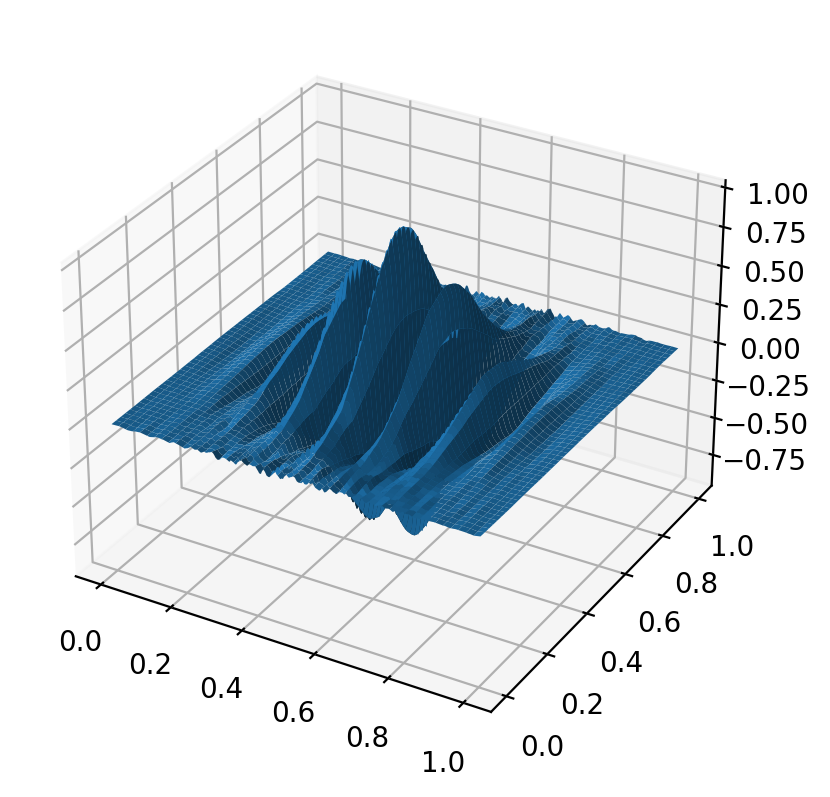

time taken:  3.906360626220703
neuron num 		 error 		 order
4 		 0.187919 		 *  

8 		 0.187356 		 0.004328 

16 		 0.182990 		 0.034011 

32 		 0.150481 		 0.282182 

64 		 0.074552 		 1.013271 

128 		 0.034475 		 1.112677 

256 		 0.014493 		 1.250163 

512 		 0.005628 		 1.364608 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order $O(n^{-1.25})$  \\ \hline \hline 
4 		 & 0.187919 &		 *  \\ \hline  

8 		 &  1.874e-01 &  		 0.00 \\ \hline  

16 		 &  1.830e-01 &  		 0.03 \\ \hline  

32 		 &  1.505e-01 &  		 0.28 \\ \hline  

64 		 &  7.455e-02 &  		 1.01 \\ \hline  

128 		 &  3.448e-02 &  		 1.11 \\ \hline  

256 		 &  1.449e-02 &  		 1.25 \\ \hline  

512 		 &  5.628e-03 &  		 1.36 \\ \hline  

using linear solver:  direct
epoch:  1	assembling the matrix time taken:  0.000270843505859375
solving Ax = b time taken:  0.00017189979553222656
epoch:  2	assembling the matrix time taken:  0.0002796649932861328
solving Ax = b time taken:  0.00017905235290527344
epoch:  3	assembling the matrix

epoch:  74	assembling the matrix time taken:  0.0003094673156738281
solving Ax = b time taken:  0.0003731250762939453
epoch:  75	assembling the matrix time taken:  0.000293731689453125
solving Ax = b time taken:  0.0003650188446044922
epoch:  76	assembling the matrix time taken:  0.0002949237823486328
solving Ax = b time taken:  0.00036454200744628906
epoch:  77	assembling the matrix time taken:  0.0002849102020263672
solving Ax = b time taken:  0.0003724098205566406
epoch:  78	assembling the matrix time taken:  0.00029587745666503906
solving Ax = b time taken:  0.00037407875061035156
epoch:  79	assembling the matrix time taken:  0.0002841949462890625
solving Ax = b time taken:  0.00037598609924316406
epoch:  80	assembling the matrix time taken:  0.0002961158752441406
solving Ax = b time taken:  0.0003800392150878906
epoch:  81	assembling the matrix time taken:  0.00029206275939941406
solving Ax = b time taken:  0.0003993511199951172
epoch:  82	assembling the matrix time taken:  0.0002

epoch:  173	assembling the matrix time taken:  0.0008728504180908203
solving Ax = b time taken:  0.00077056884765625
epoch:  174	assembling the matrix time taken:  0.00032591819763183594
solving Ax = b time taken:  0.0008115768432617188
epoch:  175	assembling the matrix time taken:  0.00029778480529785156
solving Ax = b time taken:  0.0008327960968017578
epoch:  176	assembling the matrix time taken:  0.0003223419189453125
solving Ax = b time taken:  0.0008006095886230469
epoch:  177	assembling the matrix time taken:  0.00029850006103515625
solving Ax = b time taken:  0.0008635520935058594
epoch:  178	assembling the matrix time taken:  0.0003211498260498047
solving Ax = b time taken:  0.0008602142333984375
epoch:  179	assembling the matrix time taken:  0.0003006458282470703
solving Ax = b time taken:  0.0008616447448730469
epoch:  180	assembling the matrix time taken:  0.0003142356872558594
solving Ax = b time taken:  0.0008692741394042969
epoch:  181	assembling the matrix time taken:  

solving Ax = b time taken:  0.001688241958618164
epoch:  246	assembling the matrix time taken:  0.0003101825714111328
solving Ax = b time taken:  0.0013358592987060547
epoch:  247	assembling the matrix time taken:  0.00029397010803222656
solving Ax = b time taken:  0.0013480186462402344
epoch:  248	assembling the matrix time taken:  0.00030684471130371094
solving Ax = b time taken:  0.001295328140258789
epoch:  249	assembling the matrix time taken:  0.00029587745666503906
solving Ax = b time taken:  0.001352071762084961
epoch:  250	assembling the matrix time taken:  0.0002994537353515625
solving Ax = b time taken:  0.0013589859008789062
epoch:  251	assembling the matrix time taken:  0.0002880096435546875
solving Ax = b time taken:  0.0013680458068847656
epoch:  252	assembling the matrix time taken:  0.0003001689910888672
solving Ax = b time taken:  0.0013592243194580078
epoch:  253	assembling the matrix time taken:  0.00045013427734375
solving Ax = b time taken:  0.0012161731719970703


epoch:  330	assembling the matrix time taken:  0.0003299713134765625
solving Ax = b time taken:  0.0019986629486083984
epoch:  331	assembling the matrix time taken:  0.0002999305725097656
solving Ax = b time taken:  0.0021228790283203125
epoch:  332	assembling the matrix time taken:  0.0003159046173095703
solving Ax = b time taken:  0.002104520797729492
epoch:  333	assembling the matrix time taken:  0.0002980232238769531
solving Ax = b time taken:  0.0021398067474365234
epoch:  334	assembling the matrix time taken:  0.00031495094299316406
solving Ax = b time taken:  0.002154827117919922
epoch:  335	assembling the matrix time taken:  0.00029015541076660156
solving Ax = b time taken:  0.0021457672119140625
epoch:  336	assembling the matrix time taken:  0.0003147125244140625
solving Ax = b time taken:  0.00211334228515625
epoch:  337	assembling the matrix time taken:  0.00029778480529785156
solving Ax = b time taken:  0.0021729469299316406
epoch:  338	assembling the matrix time taken:  0.

solving Ax = b time taken:  0.0025751590728759766
epoch:  401	assembling the matrix time taken:  0.0002961158752441406
solving Ax = b time taken:  0.0027348995208740234
epoch:  402	assembling the matrix time taken:  0.00031185150146484375
solving Ax = b time taken:  0.002710103988647461
epoch:  403	assembling the matrix time taken:  0.0002911090850830078
solving Ax = b time taken:  0.002751588821411133
epoch:  404	assembling the matrix time taken:  0.0003204345703125
solving Ax = b time taken:  0.002665996551513672
epoch:  405	assembling the matrix time taken:  0.00029015541076660156
solving Ax = b time taken:  0.0027565956115722656
epoch:  406	assembling the matrix time taken:  0.0003116130828857422
solving Ax = b time taken:  0.0027320384979248047
epoch:  407	assembling the matrix time taken:  0.0002980232238769531
solving Ax = b time taken:  0.0027565956115722656
epoch:  408	assembling the matrix time taken:  0.0003123283386230469
solving Ax = b time taken:  0.002682209014892578
epo

epoch:  481	assembling the matrix time taken:  0.00031304359436035156
solving Ax = b time taken:  0.0032787322998046875
epoch:  482	assembling the matrix time taken:  0.0003216266632080078
solving Ax = b time taken:  0.0034155845642089844
epoch:  483	assembling the matrix time taken:  0.0002911090850830078
solving Ax = b time taken:  0.0033867359161376953
epoch:  484	assembling the matrix time taken:  0.00031185150146484375
solving Ax = b time taken:  0.0033342838287353516
epoch:  485	assembling the matrix time taken:  0.000293731689453125
solving Ax = b time taken:  0.0034017562866210938
epoch:  486	assembling the matrix time taken:  0.0003142356872558594
solving Ax = b time taken:  0.003396272659301758
epoch:  487	assembling the matrix time taken:  0.0002925395965576172
solving Ax = b time taken:  0.0034093856811523438
epoch:  488	assembling the matrix time taken:  0.0003132820129394531
solving Ax = b time taken:  0.003348827362060547
epoch:  489	assembling the matrix time taken:  0.

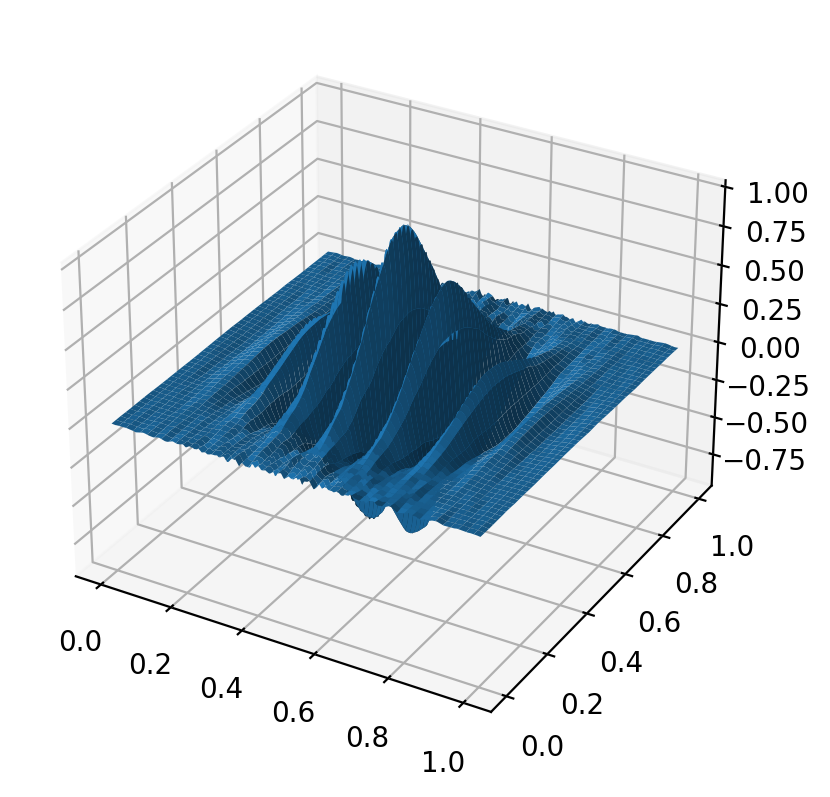

time taken:  3.819347858428955
neuron num 		 error 		 order
4 		 0.187962 		 *  

8 		 0.186846 		 0.008587 

16 		 0.175859 		 0.087431 

32 		 0.137906 		 0.350733 

64 		 0.060054 		 1.199364 

128 		 0.030109 		 0.996063 

256 		 0.011712 		 1.362160 

512 		 0.004861 		 1.268773 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order $O(n^{-1.25})$  \\ \hline \hline 
4 		 & 0.187962 &		 *  \\ \hline  

8 		 &  1.868e-01 &  		 0.01 \\ \hline  

16 		 &  1.759e-01 &  		 0.09 \\ \hline  

32 		 &  1.379e-01 &  		 0.35 \\ \hline  

64 		 &  6.005e-02 &  		 1.20 \\ \hline  

128 		 &  3.011e-02 &  		 1.00 \\ \hline  

256 		 &  1.171e-02 &  		 1.36 \\ \hline  

512 		 &  4.861e-03 &  		 1.27 \\ \hline  

using linear solver:  direct
epoch:  1	assembling the matrix time taken:  0.0004189014434814453
solving Ax = b time taken:  0.00018358230590820312
epoch:  2	assembling the matrix time taken:  0.0002682209014892578
solving Ax = b time taken:  0.0001933574676513672
epoch:  3	assembling the matrix

epoch:  160	assembling the matrix time taken:  0.0003147125244140625
solving Ax = b time taken:  0.0006933212280273438
epoch:  161	assembling the matrix time taken:  0.0002999305725097656
solving Ax = b time taken:  0.0007803440093994141
epoch:  162	assembling the matrix time taken:  0.0003046989440917969
solving Ax = b time taken:  0.0007739067077636719
epoch:  163	assembling the matrix time taken:  0.0002880096435546875
solving Ax = b time taken:  0.0007908344268798828
epoch:  164	assembling the matrix time taken:  0.0003032684326171875
solving Ax = b time taken:  0.0007741451263427734
epoch:  165	assembling the matrix time taken:  0.00029850006103515625
solving Ax = b time taken:  0.0007958412170410156
epoch:  166	assembling the matrix time taken:  0.0003018379211425781
solving Ax = b time taken:  0.000797271728515625
epoch:  167	assembling the matrix time taken:  0.0002894401550292969
solving Ax = b time taken:  0.0008046627044677734
epoch:  168	assembling the matrix time taken:  0

solving Ax = b time taken:  0.0011141300201416016
epoch:  231	assembling the matrix time taken:  0.00029587745666503906
solving Ax = b time taken:  0.001218557357788086
epoch:  232	assembling the matrix time taken:  0.00030517578125
solving Ax = b time taken:  0.0012154579162597656
epoch:  233	assembling the matrix time taken:  0.0002999305725097656
solving Ax = b time taken:  0.0012242794036865234
epoch:  234	assembling the matrix time taken:  0.00030612945556640625
solving Ax = b time taken:  0.0012395381927490234
epoch:  235	assembling the matrix time taken:  0.0002875328063964844
solving Ax = b time taken:  0.0012614727020263672
epoch:  236	assembling the matrix time taken:  0.00030040740966796875
solving Ax = b time taken:  0.0012509822845458984
epoch:  237	assembling the matrix time taken:  0.0002951622009277344
solving Ax = b time taken:  0.0012631416320800781
epoch:  238	assembling the matrix time taken:  0.00029969215393066406
solving Ax = b time taken:  0.0012688636779785156


epoch:  315	assembling the matrix time taken:  0.00030732154846191406
solving Ax = b time taken:  0.001836538314819336
epoch:  316	assembling the matrix time taken:  0.0003082752227783203
solving Ax = b time taken:  0.0019371509552001953
epoch:  317	assembling the matrix time taken:  0.000293731689453125
solving Ax = b time taken:  0.001958131790161133
epoch:  318	assembling the matrix time taken:  0.00030517578125
solving Ax = b time taken:  0.001951456069946289
epoch:  319	assembling the matrix time taken:  0.0002923011779785156
solving Ax = b time taken:  0.001965761184692383
epoch:  320	assembling the matrix time taken:  0.00030612945556640625
solving Ax = b time taken:  0.0019426345825195312
epoch:  321	assembling the matrix time taken:  0.00029540061950683594
solving Ax = b time taken:  0.0020852088928222656
epoch:  322	assembling the matrix time taken:  0.00031495094299316406
solving Ax = b time taken:  0.002090930938720703
epoch:  323	assembling the matrix time taken:  0.000293

solving Ax = b time taken:  0.0026450157165527344
epoch:  386	assembling the matrix time taken:  0.00032711029052734375
solving Ax = b time taken:  0.0025854110717773438
epoch:  387	assembling the matrix time taken:  0.0002944469451904297
solving Ax = b time taken:  0.0026421546936035156
epoch:  388	assembling the matrix time taken:  0.0003228187561035156
solving Ax = b time taken:  0.002576112747192383
epoch:  389	assembling the matrix time taken:  0.00029468536376953125
solving Ax = b time taken:  0.002660036087036133
epoch:  390	assembling the matrix time taken:  0.0003139972686767578
solving Ax = b time taken:  0.002610445022583008
epoch:  391	assembling the matrix time taken:  0.0002956390380859375
solving Ax = b time taken:  0.002661466598510742
epoch:  392	assembling the matrix time taken:  0.0003218650817871094
solving Ax = b time taken:  0.002584695816040039
epoch:  393	assembling the matrix time taken:  0.0002963542938232422
solving Ax = b time taken:  0.0026726722717285156
e

epoch:  465	assembling the matrix time taken:  0.00030517578125
solving Ax = b time taken:  0.003121614456176758
epoch:  466	assembling the matrix time taken:  0.0003209114074707031
solving Ax = b time taken:  0.003230571746826172
epoch:  467	assembling the matrix time taken:  0.0002956390380859375
solving Ax = b time taken:  0.003240346908569336
epoch:  468	assembling the matrix time taken:  0.0003154277801513672
solving Ax = b time taken:  0.0031960010528564453
epoch:  469	assembling the matrix time taken:  0.0002963542938232422
solving Ax = b time taken:  0.0032494068145751953
epoch:  470	assembling the matrix time taken:  0.00032329559326171875
solving Ax = b time taken:  0.0032329559326171875
epoch:  471	assembling the matrix time taken:  0.0003025531768798828
solving Ax = b time taken:  0.003255128860473633
epoch:  472	assembling the matrix time taken:  0.0003223419189453125
solving Ax = b time taken:  0.0032088756561279297
epoch:  473	assembling the matrix time taken:  0.0002989

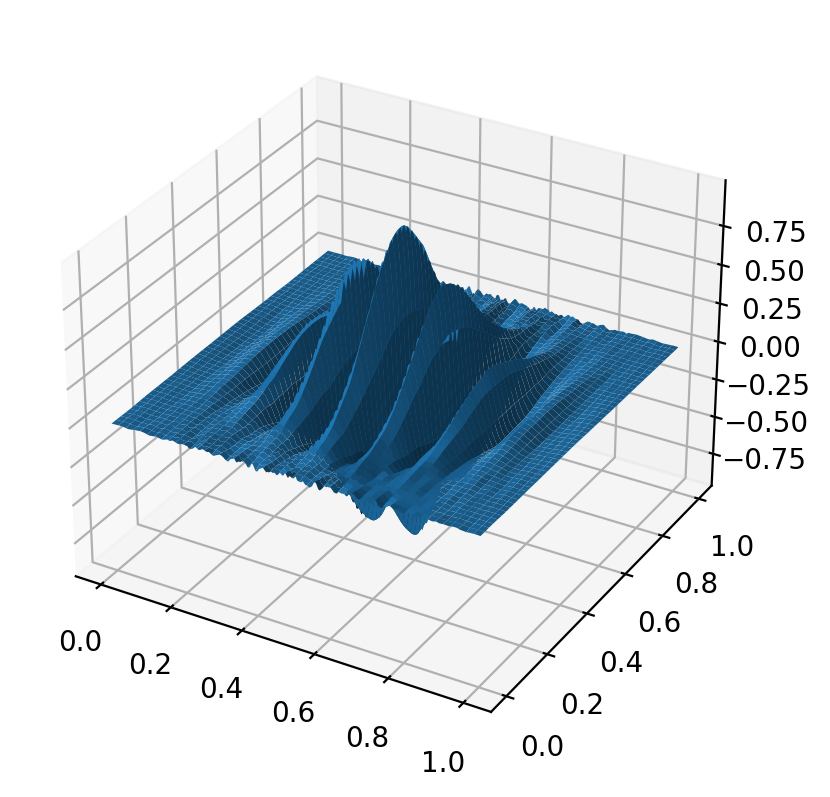

time taken:  4.068035125732422
neuron num 		 error 		 order
4 		 0.186913 		 *  

8 		 0.184797 		 0.016432 

16 		 0.166360 		 0.151631 

32 		 0.116535 		 0.513541 

64 		 0.066455 		 0.810314 

128 		 0.030999 		 1.100162 

256 		 0.011728 		 1.402302 

512 		 0.004365 		 1.425875 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order $O(n^{-1.25})$  \\ \hline \hline 
4 		 & 0.186913 &		 *  \\ \hline  

8 		 &  1.848e-01 &  		 0.02 \\ \hline  

16 		 &  1.664e-01 &  		 0.15 \\ \hline  

32 		 &  1.165e-01 &  		 0.51 \\ \hline  

64 		 &  6.646e-02 &  		 0.81 \\ \hline  

128 		 &  3.100e-02 &  		 1.10 \\ \hline  

256 		 &  1.173e-02 &  		 1.40 \\ \hline  

512 		 &  4.365e-03 &  		 1.43 \\ \hline  



In [13]:

def target(x):
    sigma = 0.15# s.d of Gaussian 
    frequency = 8  # frequency of cosine 
    z=  torch.exp( - ( (x[:,0:1]-0.5)**2 + ( x[:,1:2] -0.5)**2)  / (2*sigma**2)) *  torch.cos(2 * pi * frequency * x[:,0:1])
    return z 

function_name = "gabor2d" 
filename_write = "data/2DQMCOGA-{}-order.txt".format(function_name)
Nx = 50
order = 3
f_write = open(filename_write, "a")
f_write.write("Integration points: Nx {}, order {} \n".format(Nx,order))
f_write.close() 

save = True 
write2file = True

for N0 in [2*3,2**4,2**5,2**6,2**7]: 
    save = True 
    f_write = open(filename_write, "a")
    my_model = None 
    s = 2**3  
    Nx = 50 
    order = 3    
    exponent = 9  
    num_epochs = 2**exponent  
    plot_freq = num_epochs
    relu_k = 1  
    err_QMC2, my_model = OGAL2FittingReLU2D_QMC(my_model,target,s,N0,num_epochs,plot_freq, Nx, order, k =relu_k, linear_solver = "direct")
    
    if save: 
        folder = 'data/'
        filename = folder + 'err_OGA_2D_{}_neuron_{}_N_{}_randomized.pt'.format(function_name,num_epochs,s*N0)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_OGA_2D_{}_neuron_{}_N_{}_randomized.pt'.format(function_name,num_epochs,s*N0)
        torch.save(my_model,filename)

    show_convergence_order(err_QMC2,exponent,N,filename_write,write2file = write2file)
    show_convergence_order_latex(err_QMC2,exponent,k=relu_k,d=2)


### $\sin(\pi x_1) \sin(\pi x_2)$ 

In [5]:
## deterministic dictionary 
def target(x):
    return torch.sin(pi*x[:,0:1])*torch.sin(pi*x[:,1:2]) 

save =False 
exponent = 8  
num_epochs= 2**exponent
plot_freq = 2**exponent+1 
Nx = 50 
order = 3 
err_list_deterministic = [] 
dictionary_size_deterministic = [[2**7,2**7]]
for N_list in dictionary_size_deterministic:  # 
    my_model = None 

    err, my_model = OGAL2FittingReLU2D(my_model,target,N_list,
                            num_epochs,plot_freq, Nx, order, k =1, linear_solver = "ls")


    err_list_deterministic.append(err)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    errs = [err[i] for i in neuron_nums ]
    
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(errs):
        if i == 0: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t")
            print("*")
        else: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t") 
            print(np.log(errs[i-1]/errs[i])/np.log(2))
if save:           
    torch.save(err_list_deterministic, "2Dsinx1sinx2_err_list_deterministic.pt")



using linear solver:  ls
epoch:  1	assembling the matrix time taken:  0.00045609474182128906
solving Ax = b time taken:  0.0419011116027832
epoch:  2	assembling the matrix time taken:  0.00559687614440918
solving Ax = b time taken:  0.013386726379394531
epoch:  3	assembling the matrix time taken:  0.00020599365234375
solving Ax = b time taken:  0.000171661376953125
epoch:  4	assembling the matrix time taken:  0.00019478797912597656
solving Ax = b time taken:  0.00013327598571777344
epoch:  5	assembling the matrix time taken:  0.00019669532775878906
solving Ax = b time taken:  0.00013065338134765625
epoch:  6	assembling the matrix time taken:  0.00019931793212890625
solving Ax = b time taken:  0.00013327598571777344
epoch:  7	assembling the matrix time taken:  0.00020384788513183594
solving Ax = b time taken:  0.00013446807861328125
epoch:  8	assembling the matrix time taken:  0.00019598007202148438
solving Ax = b time taken:  0.00013327598571777344
epoch:  9	assembling the matrix time 

epoch:  74	assembling the matrix time taken:  0.0002243518829345703
solving Ax = b time taken:  0.0008533000946044922
epoch:  75	assembling the matrix time taken:  0.00021457672119140625
solving Ax = b time taken:  0.0007889270782470703
epoch:  76	assembling the matrix time taken:  0.00022149085998535156
solving Ax = b time taken:  0.0007846355438232422
epoch:  77	assembling the matrix time taken:  0.0002052783966064453
solving Ax = b time taken:  0.0008287429809570312
epoch:  78	assembling the matrix time taken:  0.0002288818359375
solving Ax = b time taken:  0.0008044242858886719
epoch:  79	assembling the matrix time taken:  0.0002067089080810547
solving Ax = b time taken:  0.0008530616760253906
epoch:  80	assembling the matrix time taken:  0.00022125244140625
solving Ax = b time taken:  0.0008292198181152344
epoch:  81	assembling the matrix time taken:  0.0002052783966064453
solving Ax = b time taken:  0.0008952617645263672
epoch:  82	assembling the matrix time taken:  0.00022721290

epoch:  144	assembling the matrix time taken:  0.00022101402282714844
solving Ax = b time taken:  0.002287626266479492
epoch:  145	assembling the matrix time taken:  0.00020360946655273438
solving Ax = b time taken:  0.0024728775024414062
epoch:  146	assembling the matrix time taken:  0.00022101402282714844
solving Ax = b time taken:  0.0024492740631103516
epoch:  147	assembling the matrix time taken:  0.0002052783966064453
solving Ax = b time taken:  0.0025548934936523438
epoch:  148	assembling the matrix time taken:  0.00021910667419433594
solving Ax = b time taken:  0.002446889877319336
epoch:  149	assembling the matrix time taken:  0.00020456314086914062
solving Ax = b time taken:  0.002619504928588867
epoch:  150	assembling the matrix time taken:  0.0002148151397705078
solving Ax = b time taken:  0.0025701522827148438
epoch:  151	assembling the matrix time taken:  0.00020456314086914062
solving Ax = b time taken:  0.0027234554290771484
epoch:  152	assembling the matrix time taken:

solving Ax = b time taken:  0.006172657012939453
epoch:  214	assembling the matrix time taken:  0.0002231597900390625
solving Ax = b time taken:  0.005232334136962891
epoch:  215	assembling the matrix time taken:  0.0002090930938720703
solving Ax = b time taken:  0.005338430404663086
epoch:  216	assembling the matrix time taken:  0.00022292137145996094
solving Ax = b time taken:  0.006632804870605469
epoch:  217	assembling the matrix time taken:  0.0010275840759277344
solving Ax = b time taken:  0.005388975143432617
epoch:  218	assembling the matrix time taken:  0.00022554397583007812
solving Ax = b time taken:  0.005449771881103516
epoch:  219	assembling the matrix time taken:  0.00021505355834960938
solving Ax = b time taken:  0.005688190460205078
epoch:  220	assembling the matrix time taken:  0.00022125244140625
solving Ax = b time taken:  0.005368232727050781
epoch:  221	assembling the matrix time taken:  0.0002193450927734375
solving Ax = b time taken:  0.005782365798950195
epoch:

In [14]:
## random dictionary 
def target(x):
    return torch.sin(pi*x[:,0:1])*torch.sin(pi*x[:,1:2]) 

exponent = 9 
num_epochs=  2**exponent 
plot_freq = 2**exponent +1
err_list_random = [] 

for s in [2**2]: 
    my_model = None 
    N0 = 2**6 
    Nx = 50 
    order = 3 
    err, my_model = OGAL2FittingReLU2D_QMC(my_model,target,s,N0,num_epochs,plot_freq, Nx, order, k =1, linear_solver = "direct")
    err_list_random.append(err)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err[i] for i in neuron_nums ]
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t")
            print("*")
        else: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t") 
            print(np.log(err_list[i-1]/err_list[i])/np.log(2))
if save:  
    torch.save(err_list_random, "2Dsinx1sinx2_err_list_random.pt")



using linear solver:  direct
epoch:  1	assembling the matrix time taken:  0.00022602081298828125
solving Ax = b time taken:  0.00018334388732910156
epoch:  2	assembling the matrix time taken:  0.00020575523376464844
solving Ax = b time taken:  0.00014328956604003906
epoch:  3	assembling the matrix time taken:  0.00019311904907226562
solving Ax = b time taken:  0.0001342296600341797
epoch:  4	assembling the matrix time taken:  0.00018858909606933594
solving Ax = b time taken:  0.0001201629638671875
epoch:  5	assembling the matrix time taken:  0.00018978118896484375
solving Ax = b time taken:  0.00012350082397460938
epoch:  6	assembling the matrix time taken:  0.0001862049102783203
solving Ax = b time taken:  0.00011992454528808594
epoch:  7	assembling the matrix time taken:  0.000186920166015625
solving Ax = b time taken:  0.00013065338134765625
epoch:  8	assembling the matrix time taken:  0.00018906593322753906
solving Ax = b time taken:  0.00013303756713867188
epoch:  9	assembling the

solving Ax = b time taken:  0.0009405612945556641
epoch:  119	assembling the matrix time taken:  0.000213623046875
solving Ax = b time taken:  0.0009324550628662109
epoch:  120	assembling the matrix time taken:  0.00025177001953125
solving Ax = b time taken:  0.0008819103240966797
epoch:  121	assembling the matrix time taken:  0.00023293495178222656
solving Ax = b time taken:  0.0009298324584960938
epoch:  122	assembling the matrix time taken:  0.00023365020751953125
solving Ax = b time taken:  0.0009219646453857422
epoch:  123	assembling the matrix time taken:  0.0002484321594238281
solving Ax = b time taken:  0.0009207725524902344
epoch:  124	assembling the matrix time taken:  0.00022268295288085938
solving Ax = b time taken:  0.0009465217590332031
epoch:  125	assembling the matrix time taken:  0.0002567768096923828
solving Ax = b time taken:  0.0009272098541259766
epoch:  126	assembling the matrix time taken:  0.0002334117889404297
solving Ax = b time taken:  0.0009427070617675781
e

epoch:  192	assembling the matrix time taken:  0.0002505779266357422
solving Ax = b time taken:  0.0013852119445800781
epoch:  193	assembling the matrix time taken:  0.0002315044403076172
solving Ax = b time taken:  0.0016121864318847656
epoch:  194	assembling the matrix time taken:  0.00023126602172851562
solving Ax = b time taken:  0.0016169548034667969
epoch:  195	assembling the matrix time taken:  0.00023126602172851562
solving Ax = b time taken:  0.00162506103515625
epoch:  196	assembling the matrix time taken:  0.00026035308837890625
solving Ax = b time taken:  0.0015823841094970703
epoch:  197	assembling the matrix time taken:  0.00023221969604492188
solving Ax = b time taken:  0.0016450881958007812
epoch:  198	assembling the matrix time taken:  0.00025391578674316406
solving Ax = b time taken:  0.0016186237335205078
epoch:  199	assembling the matrix time taken:  0.0002536773681640625
solving Ax = b time taken:  0.0016286373138427734
epoch:  200	assembling the matrix time taken:

epoch:  275	assembling the matrix time taken:  0.00038361549377441406
solving Ax = b time taken:  0.002421855926513672
epoch:  276	assembling the matrix time taken:  0.0002353191375732422
solving Ax = b time taken:  0.0026006698608398438
epoch:  277	assembling the matrix time taken:  0.000255584716796875
solving Ax = b time taken:  0.0026047229766845703
epoch:  278	assembling the matrix time taken:  0.0002617835998535156
solving Ax = b time taken:  0.002600431442260742
epoch:  279	assembling the matrix time taken:  0.000274658203125
solving Ax = b time taken:  0.0026023387908935547
epoch:  280	assembling the matrix time taken:  0.00023436546325683594
solving Ax = b time taken:  0.002621173858642578
epoch:  281	assembling the matrix time taken:  0.00023317337036132812
solving Ax = b time taken:  0.002652406692504883
epoch:  282	assembling the matrix time taken:  0.00023603439331054688
solving Ax = b time taken:  0.0026531219482421875
epoch:  283	assembling the matrix time taken:  0.0002

epoch:  361	assembling the matrix time taken:  0.00025177001953125
solving Ax = b time taken:  0.0034685134887695312
epoch:  362	assembling the matrix time taken:  0.0002689361572265625
solving Ax = b time taken:  0.0034732818603515625
epoch:  363	assembling the matrix time taken:  0.0002551078796386719
solving Ax = b time taken:  0.0035033226013183594
epoch:  364	assembling the matrix time taken:  0.0002510547637939453
solving Ax = b time taken:  0.0034792423248291016
epoch:  365	assembling the matrix time taken:  0.0002562999725341797
solving Ax = b time taken:  0.0035228729248046875
epoch:  366	assembling the matrix time taken:  0.00023245811462402344
solving Ax = b time taken:  0.0035436153411865234
epoch:  367	assembling the matrix time taken:  0.00022912025451660156
solving Ax = b time taken:  0.0035440921783447266
epoch:  368	assembling the matrix time taken:  0.00023293495178222656
solving Ax = b time taken:  0.0035207271575927734
epoch:  369	assembling the matrix time taken:  

epoch:  432	assembling the matrix time taken:  0.0002694129943847656
solving Ax = b time taken:  0.004343748092651367
epoch:  433	assembling the matrix time taken:  0.0002541542053222656
solving Ax = b time taken:  0.004441738128662109
epoch:  434	assembling the matrix time taken:  0.0002334117889404297
solving Ax = b time taken:  0.004468202590942383
epoch:  435	assembling the matrix time taken:  0.0002434253692626953
solving Ax = b time taken:  0.00448298454284668
epoch:  436	assembling the matrix time taken:  0.00023293495178222656
solving Ax = b time taken:  0.004448413848876953
epoch:  437	assembling the matrix time taken:  0.00025963783264160156
solving Ax = b time taken:  0.004469633102416992
epoch:  438	assembling the matrix time taken:  0.00023412704467773438
solving Ax = b time taken:  0.004487276077270508
epoch:  439	assembling the matrix time taken:  0.00023412704467773438
solving Ax = b time taken:  0.0045053958892822266
epoch:  440	assembling the matrix time taken:  0.000

epoch:  509	assembling the matrix time taken:  0.0002162456512451172
solving Ax = b time taken:  0.005172252655029297
epoch:  510	assembling the matrix time taken:  0.00021266937255859375
solving Ax = b time taken:  0.00518345832824707
epoch:  511	assembling the matrix time taken:  0.00024628639221191406
solving Ax = b time taken:  0.005141496658325195
epoch:  512	assembling the matrix time taken:  0.00023126602172851562
solving Ax = b time taken:  0.005126476287841797
time taken:  4.103647470474243
neuron num 		 error 		 order
4		tensor(0.21070406)		*
8		tensor(0.04750096)		tensor(2.14918970)
16		tensor(0.02390981)		tensor(0.99035375)
32		tensor(0.00857184)		tensor(1.47992582)
64		tensor(0.00351887)		tensor(1.28449463)
128		tensor(0.00150699)		tensor(1.22344522)
256		tensor(0.00053882)		tensor(1.48377922)
512		tensor(0.00020985)		tensor(1.36042741)


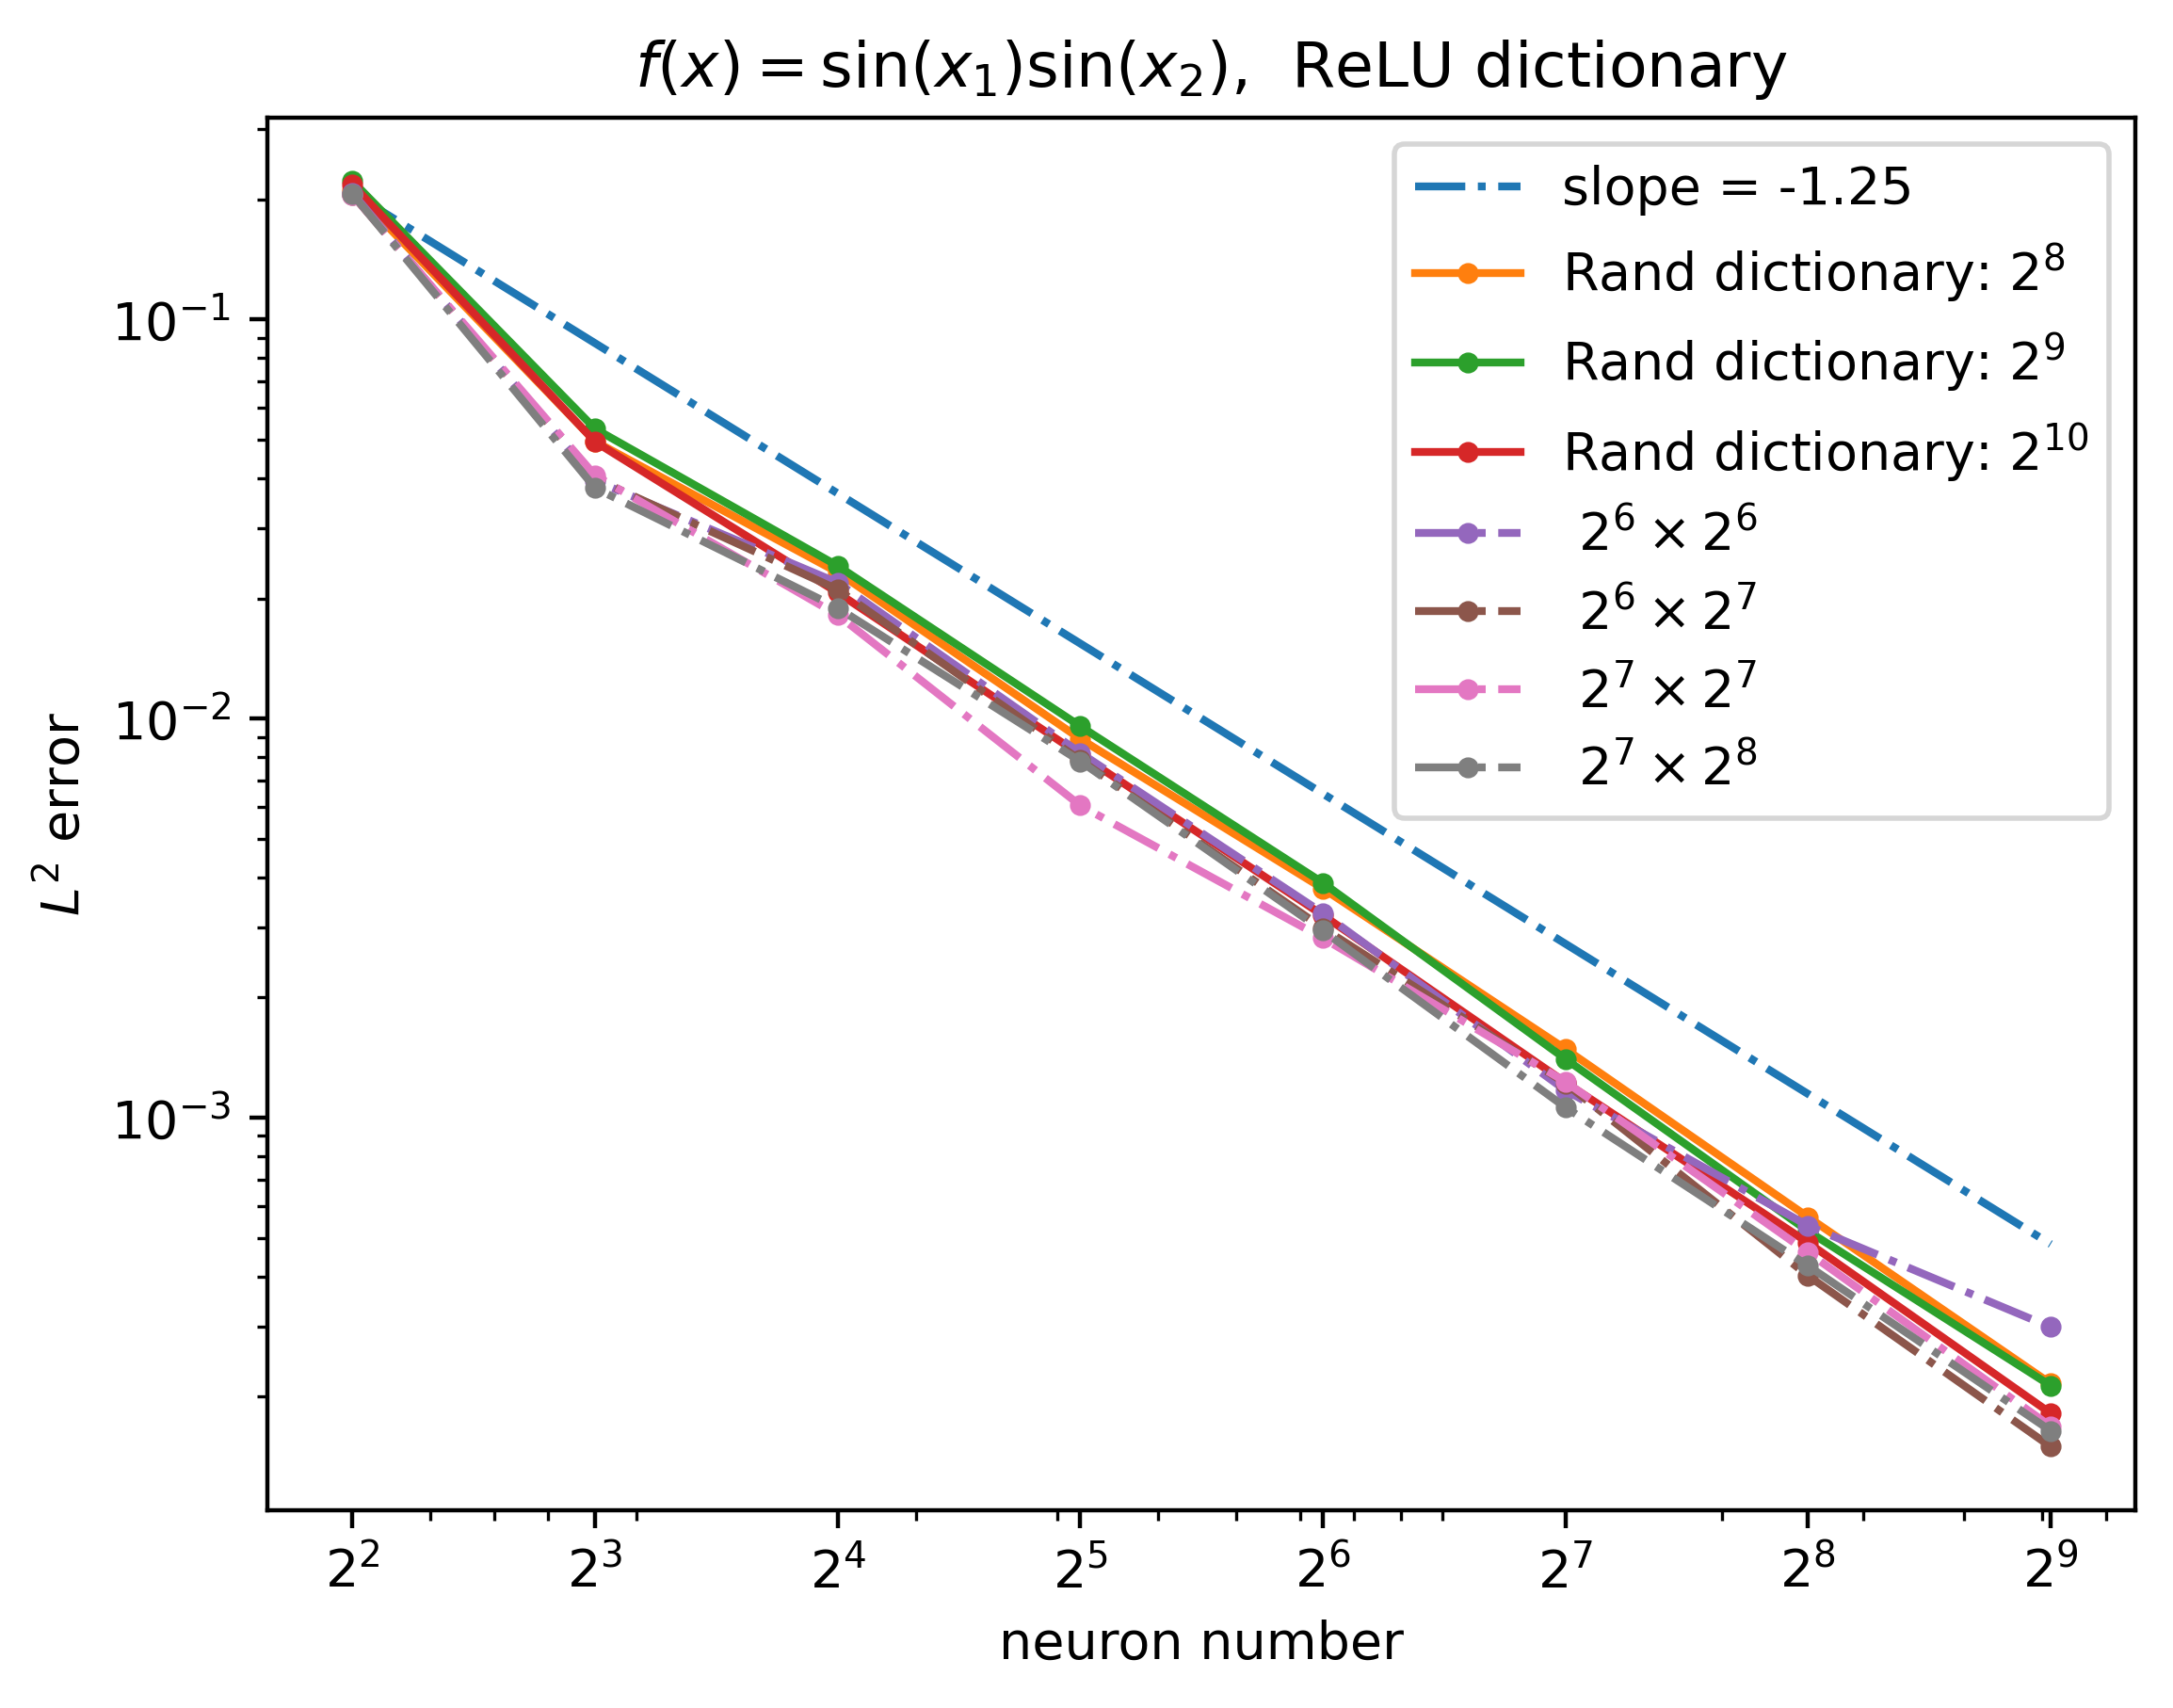

In [49]:
## plot results 

## read data: 
err_list_deterministic = torch.load("2Dsinx1sinx2_err_list_deterministic.pt")
err_list_random = torch.load("2Dsinx1sinx2_err_list_random.pt")

exponent = 9 
neuron_nums = np.array([2**j for j in range(2,exponent+1)]) 
dictionary_size_exponent_random = [8,9,10]
dictionary_size_random = [2**p for p in dictionary_size_exponent_random]
dictionary_size_deterministic = [[6,6],[6,7],[7,7],[7,8]]
plt.figure(dpi = 400)

x = np.array(range(4, 2**exponent+1))

ref = err_list_deterministic[0][2**2]* (x/ 4)**(-1.25)
plt.plot(x,ref,'-.',label = 'slope = -1.25')

for i, err in enumerate(err_list_random): 
    plt.plot(neuron_nums, err[neuron_nums],'.-',label = "Rand dictionary: $2^{{{}}}$".format(dictionary_size_exponent_random[i]))

for i, err in enumerate(err_list_deterministic): 
    plt.plot(neuron_nums, err[neuron_nums],'.-.', 
             label = " $2^{} \\times 2^{}$ ".format(dictionary_size_deterministic[i][0],dictionary_size_deterministic[i][1] ))
plt.title(" $f(x) = \sin(x_1)\sin(x_2)$,  ReLU dictionary")
plt.yscale('log')
plt.xscale('log')
# plt.grid("True")
plt.xlabel("neuron number")
plt.ylabel("$L^2$ error")
plt.xticks(neuron_nums,[rf"$2^{{{ns}}}$" for ns in range(2,exponent+1)])
plt.legend()    
plt.show()

### $\sin(4\pi x_1) \sin(8\pi x_2)$ 

In [41]:
def target(x):
    return torch.sin(4*pi*x[:,0:1])*torch.sin(8*pi*x[:,1:2]) 

## deterministic dictionary 
num_epochs= 2**exponent
plot_freq = 2**exponent+1
Nx = 50 
order = 3 
err_list_deterministic = [] 
dictionary_size_deterministic = [[6,6],[6,7],[7,7],[7,8]]
for num in dictionary_size_deterministic:  # 
    my_model = None 
    relu_dict_parameters = generate_relu_dict2D(2**num[0],2**num[1]).to(device)
    err, my_model = OGAL2FittingReLU2D(my_model,target,relu_dict_parameters,
                            num_epochs,plot_freq, Nx, order, k =1, linear_solver = "direct")

    err_list_deterministic.append(err)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    errs = [err[i] for i in neuron_nums ]
    
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(errs):
        if i == 0: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t")
            print("*")
        else: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t") 
            print(np.log(errs[i-1]/errs[i])/np.log(2))
            
torch.save(err_list_deterministic, "2Dsin4x1sin8x2_err_list_deterministic.pt")

## random dictionary 

exponent = 9 
num_epochs=  2**exponent 
plot_freq = 2**exponent+1 
err_list_random = [] 

for s in [2**2, 2**3,2**4]: 
    my_model = None 
    N0 = 2**6 
    Nx = 50 
    order = 3 
    err, my_model = OGAL2FittingReLU2D_QMC(my_model,target,s,N0,num_epochs,plot_freq, Nx, order, k =1, linear_solver = "direct")
    err_list_random.append(err)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err[i] for i in neuron_nums ]
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t")
            print("*")
        else: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t") 
            print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            
torch.save(err_list_random, "2Dsin4x1sin8x2_err_list_random.pt")



using linear solver:  direct
epoch:  1	epoch:  2	epoch:  3	epoch:  4	epoch:  5	epoch:  6	epoch:  7	epoch:  8	epoch:  9	epoch:  10	epoch:  11	epoch:  12	epoch:  13	epoch:  14	epoch:  15	epoch:  16	epoch:  17	epoch:  18	epoch:  19	epoch:  20	epoch:  21	epoch:  22	epoch:  23	epoch:  24	epoch:  25	epoch:  26	epoch:  27	epoch:  28	epoch:  29	epoch:  30	epoch:  31	epoch:  32	epoch:  33	epoch:  34	epoch:  35	epoch:  36	epoch:  37	epoch:  38	epoch:  39	epoch:  40	epoch:  41	epoch:  42	epoch:  43	epoch:  44	epoch:  45	epoch:  46	epoch:  47	epoch:  48	epoch:  49	epoch:  50	epoch:  51	epoch:  52	epoch:  53	epoch:  54	epoch:  55	epoch:  56	epoch:  57	epoch:  58	epoch:  59	epoch:  60	epoch:  61	epoch:  62	epoch:  63	epoch:  64	epoch:  65	epoch:  66	epoch:  67	epoch:  68	epoch:  69	epoch:  70	epoch:  71	epoch:  72	epoch:  73	epoch:  74	epoch:  75	epoch:  76	epoch:  77	epoch:  78	epoch:  79	epoch:  80	epoch:  81	epoch:  82	epoch:  83	epoch:  84	epoch:  85	epoch:  86	epoch:  87	epoch:  88	epoch:  89	e

epoch:  1	epoch:  2	epoch:  3	epoch:  4	epoch:  5	epoch:  6	epoch:  7	epoch:  8	epoch:  9	epoch:  10	epoch:  11	epoch:  12	epoch:  13	epoch:  14	epoch:  15	epoch:  16	epoch:  17	epoch:  18	epoch:  19	epoch:  20	epoch:  21	epoch:  22	epoch:  23	epoch:  24	epoch:  25	epoch:  26	epoch:  27	epoch:  28	epoch:  29	epoch:  30	epoch:  31	epoch:  32	epoch:  33	epoch:  34	epoch:  35	epoch:  36	epoch:  37	epoch:  38	epoch:  39	epoch:  40	epoch:  41	epoch:  42	epoch:  43	epoch:  44	epoch:  45	epoch:  46	epoch:  47	epoch:  48	epoch:  49	epoch:  50	epoch:  51	epoch:  52	epoch:  53	epoch:  54	epoch:  55	epoch:  56	epoch:  57	epoch:  58	epoch:  59	epoch:  60	epoch:  61	epoch:  62	epoch:  63	epoch:  64	epoch:  65	epoch:  66	epoch:  67	epoch:  68	epoch:  69	epoch:  70	epoch:  71	epoch:  72	epoch:  73	epoch:  74	epoch:  75	epoch:  76	epoch:  77	epoch:  78	epoch:  79	epoch:  80	epoch:  81	epoch:  82	epoch:  83	epoch:  84	epoch:  85	epoch:  86	epoch:  87	epoch:  88	epoch:  89	epoch:  90	epoch:  91	epoch:  

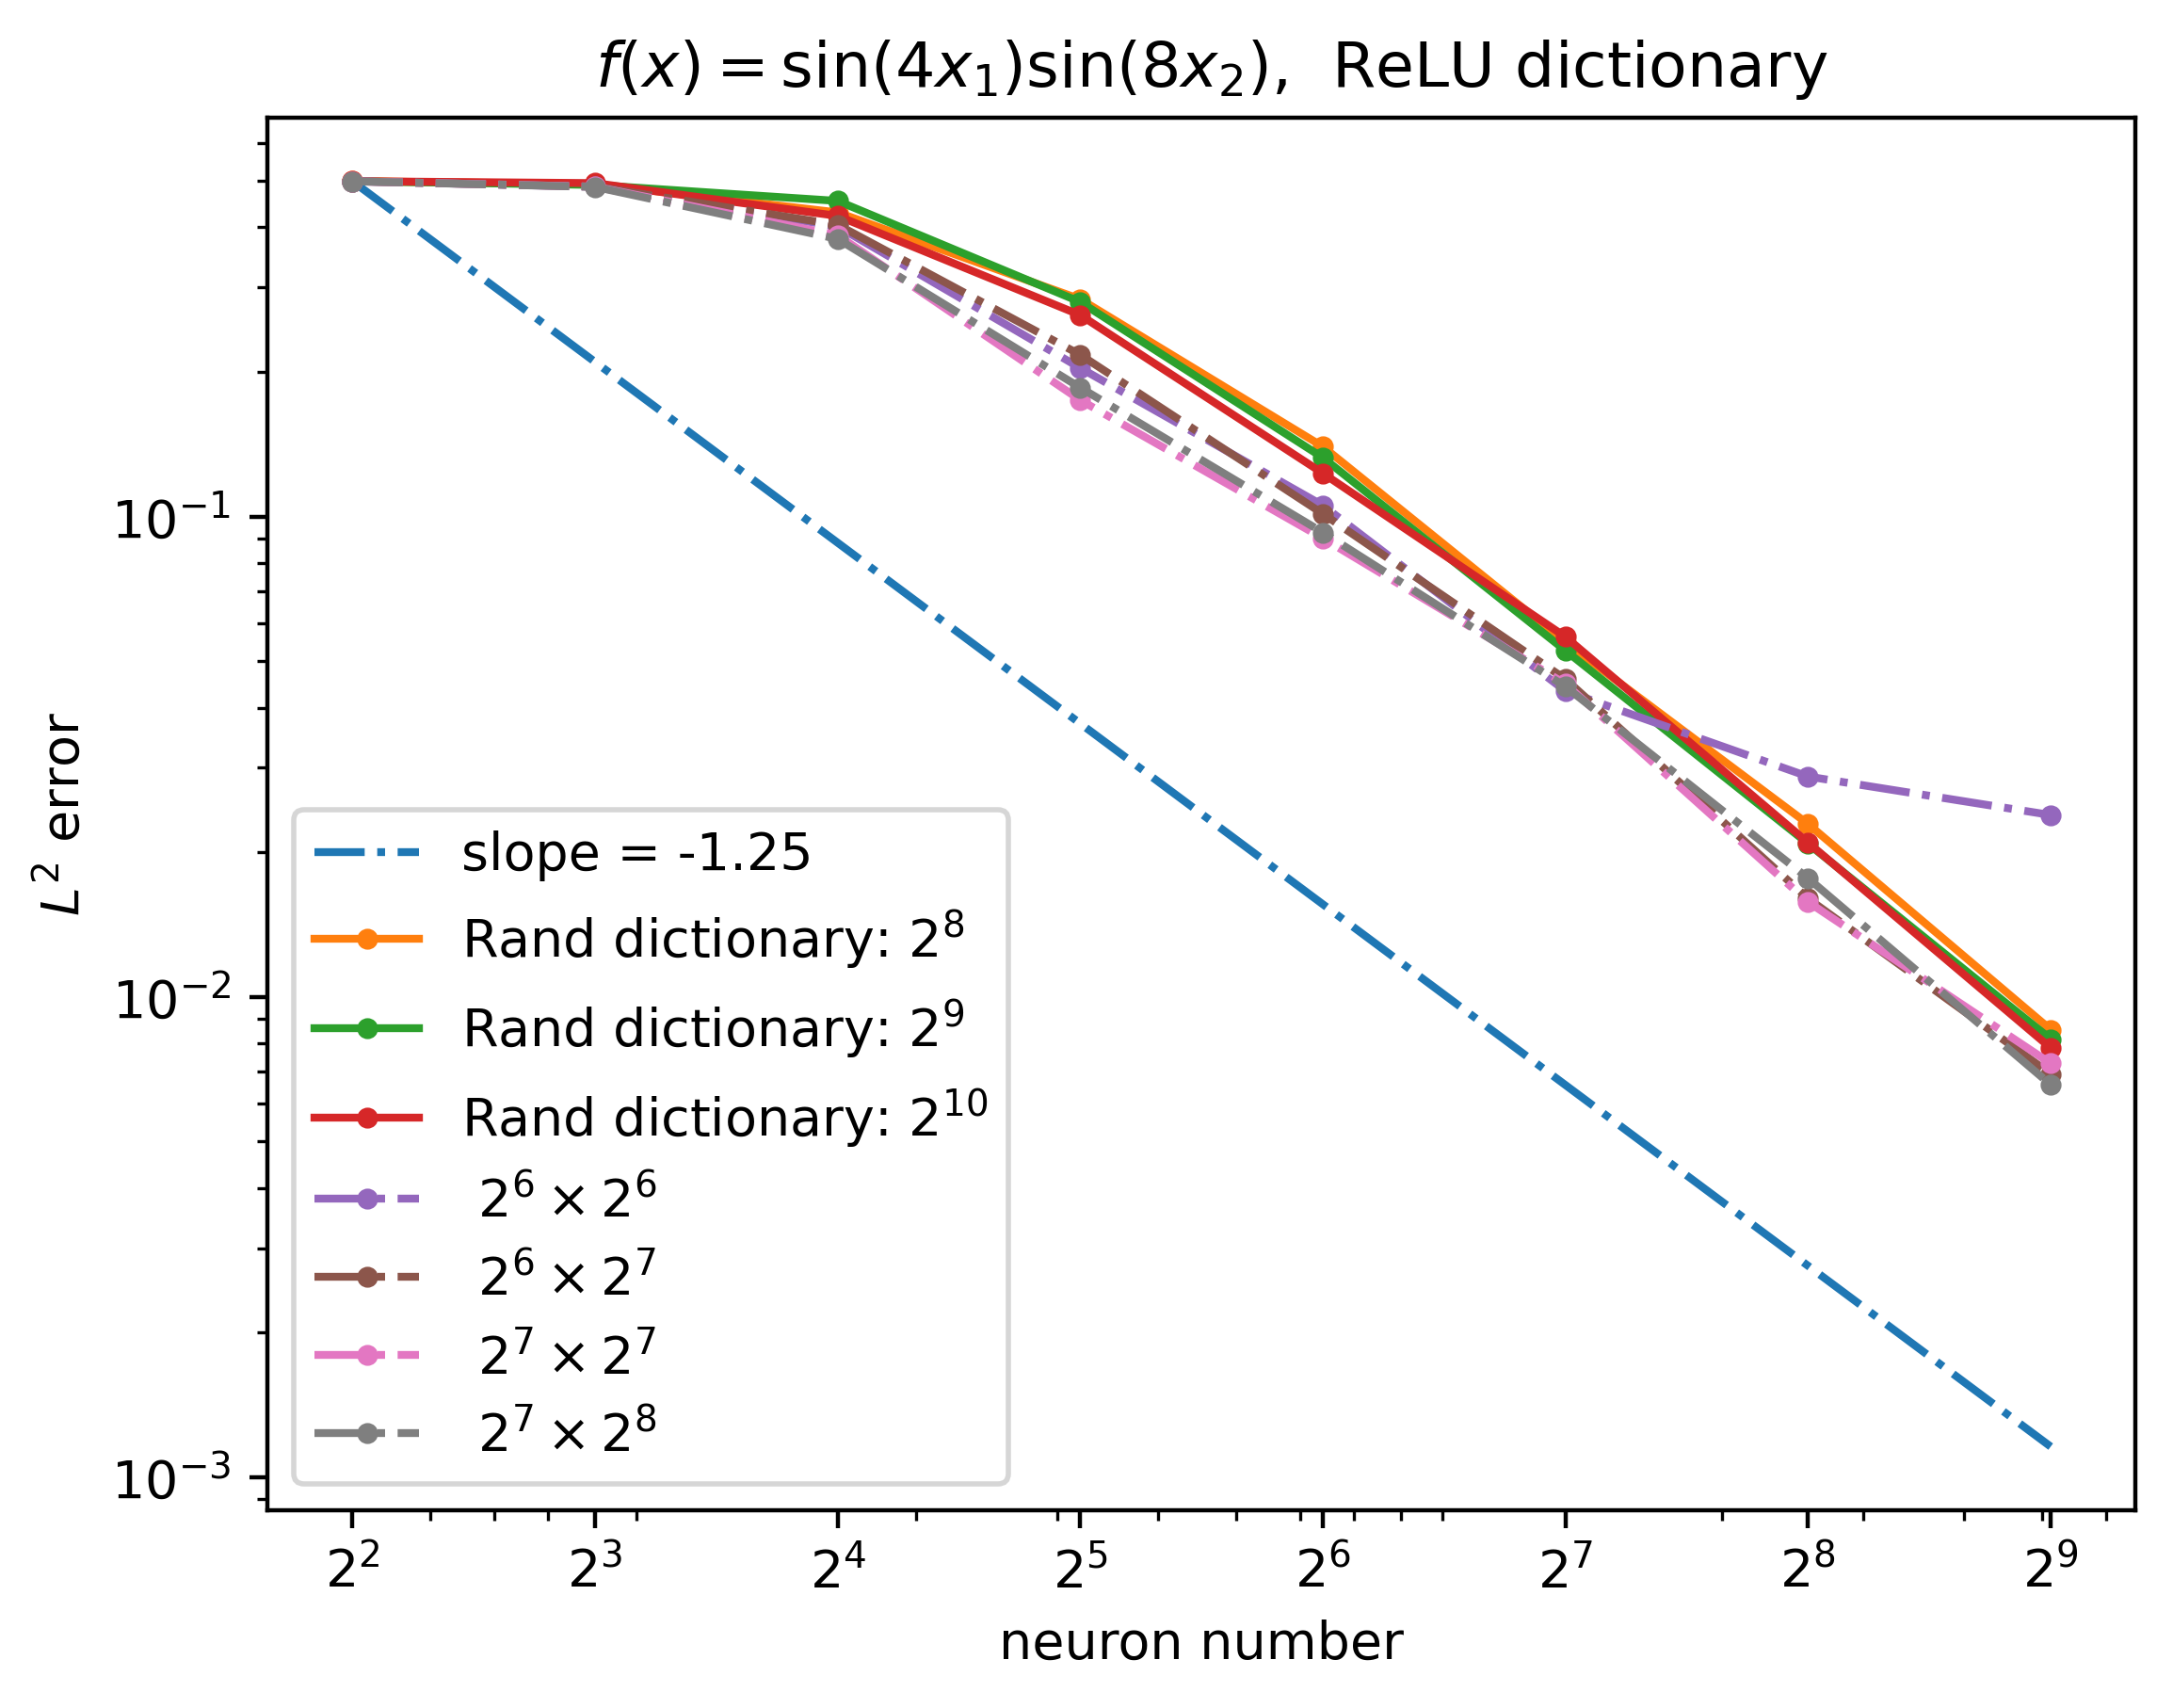

In [48]:
## plot results 

## read data: 
err_list_deterministic = torch.load("2Dsin4x1sin8x2_err_list_deterministic.pt")
err_list_random = torch.load("2Dsin4x1sin8x2_err_list_random.pt")

exponent = 9 
neuron_nums = np.array([2**j for j in range(2,exponent+1)]) 
dictionary_size_exponent_random = [8,9,10]
dictionary_size_random = [2**p for p in dictionary_size_exponent_random]
dictionary_size_deterministic = [[6,6],[6,7],[7,7],[7,8]]
plt.figure(dpi = 400)

x = np.array(range(4, 2**exponent+1))

ref = err_list_deterministic[0][2**2]* (x/ 4)**(-1.25)
plt.plot(x,ref,'-.',label = 'slope = -1.25')

for i, err in enumerate(err_list_random): 
    plt.plot(neuron_nums, err[neuron_nums],'.-',label = "Rand dictionary: $2^{{{}}}$".format(dictionary_size_exponent_random[i]))

for i, err in enumerate(err_list_deterministic): 
    plt.plot(neuron_nums, err[neuron_nums],'.-.', 
             label = " $2^{} \\times 2^{}$ ".format(dictionary_size_deterministic[i][0],dictionary_size_deterministic[i][1] ))
plt.title(" $f(x) = \sin(4x_1)\sin(8x_2)$,  ReLU dictionary")
plt.yscale('log')
plt.xscale('log')
# plt.grid("True")
plt.xlabel("neuron number")
plt.ylabel("$L^2$ error")
plt.xticks(neuron_nums,[rf"$2^{{{ns}}}$" for ns in range(2,exponent+1)])
plt.legend()    
plt.show()

### Gabor funciton 2D 

In [54]:
my_model = None 
def target(x):
    sigma = 0.15# s.d of Gaussian 
    frequency = 8  # frequency of cosine 
    z=  torch.exp( - ( (x[:,0:1]-0.5)**2 + ( x[:,1:2] -0.5)**2)  / (2*sigma**2)) *  torch.cos(2 * pi * frequency * x[:,0:1])
    return z 

exponent = 9 
num_epochs=  2**exponent 
plot_freq = 2**exponent+1 
err_list_random = [] 

for s in [2**2, 2**3,2**4]: 
    my_model = None 
    N0 = 2**6 
    Nx = 50 
    order = 3 
    err, my_model = OGAL2FittingReLU2D_QMC(my_model,target,s,N0,num_epochs,plot_freq, Nx, order, k =1, linear_solver = "direct")
    err_list_random.append(err)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err[i] for i in neuron_nums ]
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t")
            print("*")
        else: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t") 
            print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            
torch.save(err_list_random, "2DGabor_err_list_random.pt")


using linear solver:  direct
epoch:  1	epoch:  2	epoch:  3	epoch:  4	epoch:  5	epoch:  6	epoch:  7	epoch:  8	epoch:  9	epoch:  10	epoch:  11	epoch:  12	epoch:  13	epoch:  14	epoch:  15	epoch:  16	epoch:  17	epoch:  18	epoch:  19	epoch:  20	epoch:  21	epoch:  22	epoch:  23	epoch:  24	epoch:  25	epoch:  26	epoch:  27	epoch:  28	epoch:  29	epoch:  30	epoch:  31	epoch:  32	epoch:  33	epoch:  34	epoch:  35	epoch:  36	epoch:  37	epoch:  38	epoch:  39	epoch:  40	epoch:  41	epoch:  42	epoch:  43	epoch:  44	epoch:  45	epoch:  46	epoch:  47	epoch:  48	epoch:  49	epoch:  50	epoch:  51	epoch:  52	epoch:  53	epoch:  54	epoch:  55	epoch:  56	epoch:  57	epoch:  58	epoch:  59	epoch:  60	epoch:  61	epoch:  62	epoch:  63	epoch:  64	epoch:  65	epoch:  66	epoch:  67	epoch:  68	epoch:  69	epoch:  70	epoch:  71	epoch:  72	epoch:  73	epoch:  74	epoch:  75	epoch:  76	epoch:  77	epoch:  78	epoch:  79	epoch:  80	epoch:  81	epoch:  82	epoch:  83	epoch:  84	epoch:  85	epoch:  86	epoch:  87	epoch:  88	epoch:  89	e

epoch:  1	epoch:  2	epoch:  3	epoch:  4	epoch:  5	epoch:  6	epoch:  7	epoch:  8	epoch:  9	epoch:  10	epoch:  11	epoch:  12	epoch:  13	epoch:  14	epoch:  15	epoch:  16	epoch:  17	epoch:  18	epoch:  19	epoch:  20	epoch:  21	epoch:  22	epoch:  23	epoch:  24	epoch:  25	epoch:  26	epoch:  27	epoch:  28	epoch:  29	epoch:  30	epoch:  31	epoch:  32	epoch:  33	epoch:  34	epoch:  35	epoch:  36	epoch:  37	epoch:  38	epoch:  39	epoch:  40	epoch:  41	epoch:  42	epoch:  43	epoch:  44	epoch:  45	epoch:  46	epoch:  47	epoch:  48	epoch:  49	epoch:  50	epoch:  51	epoch:  52	epoch:  53	epoch:  54	epoch:  55	epoch:  56	epoch:  57	epoch:  58	epoch:  59	epoch:  60	epoch:  61	epoch:  62	epoch:  63	epoch:  64	epoch:  65	epoch:  66	epoch:  67	epoch:  68	epoch:  69	epoch:  70	epoch:  71	epoch:  72	epoch:  73	epoch:  74	epoch:  75	epoch:  76	epoch:  77	epoch:  78	epoch:  79	epoch:  80	epoch:  81	epoch:  82	epoch:  83	epoch:  84	epoch:  85	epoch:  86	epoch:  87	epoch:  88	epoch:  89	epoch:  90	epoch:  91	epoch:  

In [12]:
neuron_nums = [2**j for j in range(2,10)]
err_list = [err[i] for i in neuron_nums ]

print("neuron num \t\t error \t\t order")
for i, item in enumerate(err_list):
    if i == 0: 
        print(neuron_nums[i], end = "\t\t")
        print(item, end = "\t\t")
        print("*")
    else: 
        print(neuron_nums[i], end = "\t\t")
        print(item, end = "\t\t") 
        print(np.log(err_list[i-1]/err_list[i])/np.log(2))
    

neuron num 		 error 		 order
4		tensor(0.18746856)		*
8		tensor(0.18456400)		tensor(0.02252749)
16		tensor(0.17304419)		tensor(0.09298067)
32		tensor(0.11998072)		tensor(0.52833792)
64		tensor(0.06591547)		tensor(0.86411360)
128		tensor(0.03074313)		tensor(1.10035282)
256		tensor(0.01140568)		tensor(1.43051166)
512		tensor(0.00441209)		tensor(1.37021872)


using linear solver:  direct
epoch:  1	epoch:  2	epoch:  3	epoch:  4	epoch:  5	epoch:  6	epoch:  7	epoch:  8	epoch:  9	epoch:  10	epoch:  11	epoch:  12	epoch:  13	epoch:  14	epoch:  15	epoch:  16	epoch:  17	epoch:  18	epoch:  19	epoch:  20	epoch:  21	epoch:  22	epoch:  23	epoch:  24	epoch:  25	epoch:  26	epoch:  27	epoch:  28	epoch:  29	epoch:  30	epoch:  31	epoch:  32	epoch:  33	epoch:  34	epoch:  35	epoch:  36	epoch:  37	epoch:  38	epoch:  39	epoch:  40	epoch:  41	epoch:  42	epoch:  43	epoch:  44	epoch:  45	epoch:  46	epoch:  47	epoch:  48	epoch:  49	epoch:  50	epoch:  51	epoch:  52	epoch:  53	epoch:  54	epoch:  55	epoch:  56	epoch:  57	epoch:  58	epoch:  59	epoch:  60	epoch:  61	epoch:  62	epoch:  63	epoch:  64	epoch:  65	epoch:  66	epoch:  67	epoch:  68	epoch:  69	epoch:  70	epoch:  71	epoch:  72	epoch:  73	epoch:  74	epoch:  75	epoch:  76	epoch:  77	epoch:  78	epoch:  79	epoch:  80	epoch:  81	epoch:  82	epoch:  83	epoch:  84	epoch:  85	epoch:  86	epoch:  87	epoch:  88	epoch:  89	e

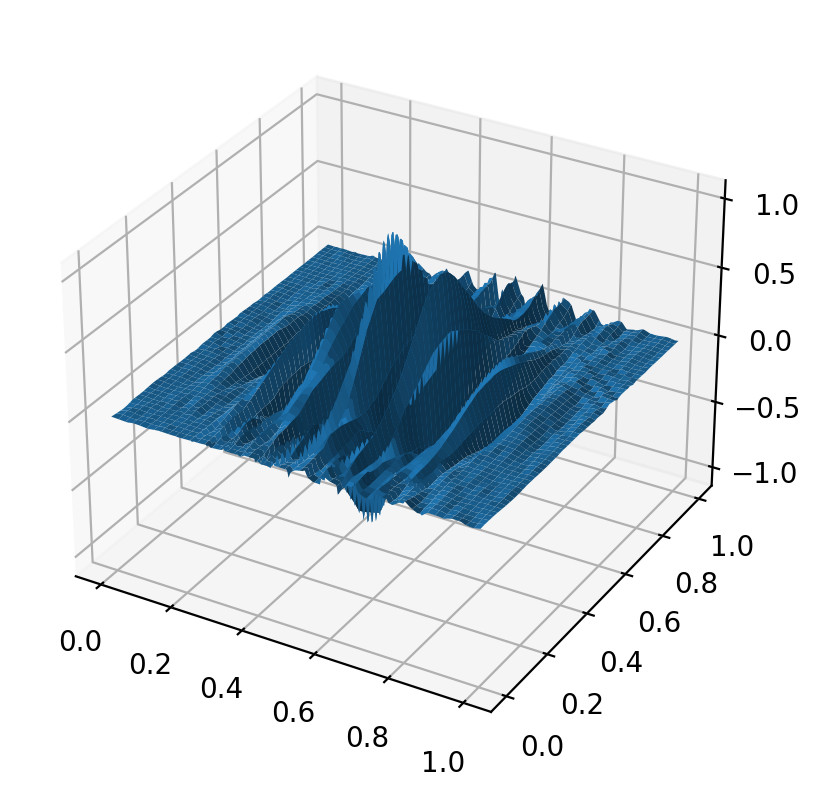

time taken:  50.13648271560669
neuron num 		 error 		 order
4		tensor(0.18676358)		*
8		tensor(0.17429207)		tensor(0.09970619)
16		tensor(0.13720771)		tensor(0.34514541)
32		tensor(0.11845465)		tensor(0.21202674)
64		tensor(0.06757468)		tensor(0.80978020)
128		tensor(0.05024533)		tensor(0.42749306)
256		tensor(0.04963082)		tensor(0.01775325)
512		tensor(0.04958918)		tensor(0.00121091)
using linear solver:  direct
epoch:  1	epoch:  2	epoch:  3	epoch:  4	epoch:  5	epoch:  6	epoch:  7	epoch:  8	epoch:  9	epoch:  10	epoch:  11	epoch:  12	epoch:  13	epoch:  14	epoch:  15	epoch:  16	epoch:  17	epoch:  18	epoch:  19	epoch:  20	epoch:  21	epoch:  22	epoch:  23	epoch:  24	epoch:  25	epoch:  26	epoch:  27	epoch:  28	epoch:  29	epoch:  30	epoch:  31	epoch:  32	epoch:  33	epoch:  34	epoch:  35	epoch:  36	epoch:  37	epoch:  38	epoch:  39	epoch:  40	epoch:  41	epoch:  42	epoch:  43	epoch:  44	epoch:  45	epoch:  46	epoch:  47	epoch:  48	epoch:  49	epoch:  50	epoch:  51	epoch:  52	epoch:  53	epoch:  5

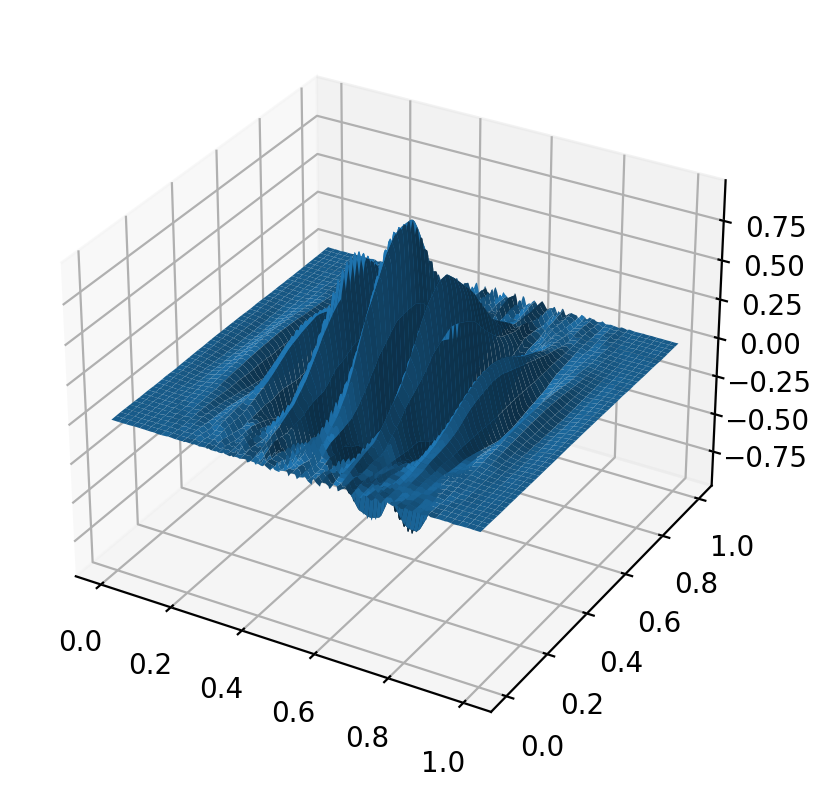

time taken:  54.75861167907715
neuron num 		 error 		 order
4		tensor(0.18593198)		*
8		tensor(0.16280500)		tensor(0.19163000)
16		tensor(0.13869569)		tensor(0.23122206)
32		tensor(0.10418308)		tensor(0.41280190)
64		tensor(0.06649248)		tensor(0.64785793)
128		tensor(0.02379158)		tensor(1.48273990)
256		tensor(0.01028773)		tensor(1.20952620)
512		tensor(0.00936732)		tensor(0.13521620)
using linear solver:  direct
epoch:  1	epoch:  2	epoch:  3	epoch:  4	epoch:  5	epoch:  6	epoch:  7	epoch:  8	epoch:  9	epoch:  10	epoch:  11	epoch:  12	epoch:  13	epoch:  14	epoch:  15	epoch:  16	epoch:  17	epoch:  18	epoch:  19	epoch:  20	epoch:  21	epoch:  22	epoch:  23	epoch:  24	epoch:  25	epoch:  26	epoch:  27	epoch:  28	epoch:  29	epoch:  30	epoch:  31	epoch:  32	epoch:  33	epoch:  34	epoch:  35	epoch:  36	epoch:  37	epoch:  38	epoch:  39	epoch:  40	epoch:  41	epoch:  42	epoch:  43	epoch:  44	epoch:  45	epoch:  46	epoch:  47	epoch:  48	epoch:  49	epoch:  50	epoch:  51	epoch:  52	epoch:  53	epoch:  5

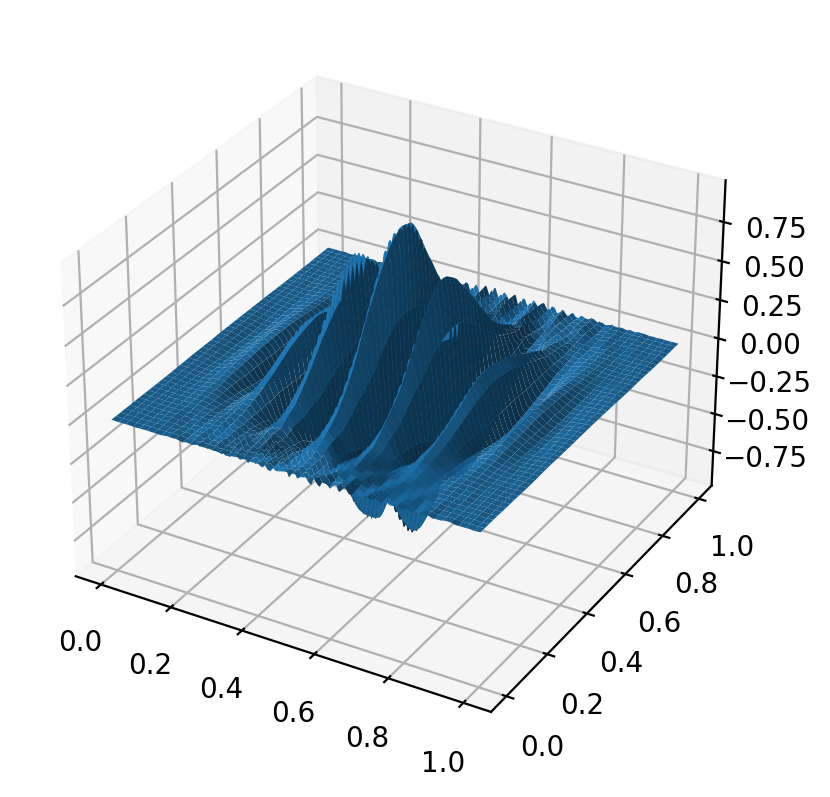

time taken:  62.14431357383728
neuron num 		 error 		 order
4		tensor(0.18593198)		*
8		tensor(0.16281163)		tensor(0.19157120)
16		tensor(0.15241313)		tensor(0.09521660)
32		tensor(0.12363460)		tensor(0.30190463)
64		tensor(0.06885179)		tensor(0.84451640)
128		tensor(0.02471193)		tensor(1.47828664)
256		tensor(0.01077886)		tensor(1.19700235)
512		tensor(0.00666565)		tensor(0.69338874)
using linear solver:  direct
epoch:  1	epoch:  2	epoch:  3	epoch:  4	epoch:  5	epoch:  6	epoch:  7	epoch:  8	epoch:  9	epoch:  10	epoch:  11	epoch:  12	epoch:  13	epoch:  14	epoch:  15	epoch:  16	epoch:  17	epoch:  18	epoch:  19	epoch:  20	epoch:  21	epoch:  22	epoch:  23	epoch:  24	epoch:  25	epoch:  26	epoch:  27	epoch:  28	epoch:  29	epoch:  30	epoch:  31	epoch:  32	epoch:  33	epoch:  34	epoch:  35	epoch:  36	epoch:  37	epoch:  38	epoch:  39	epoch:  40	epoch:  41	epoch:  42	epoch:  43	epoch:  44	epoch:  45	epoch:  46	epoch:  47	epoch:  48	epoch:  49	epoch:  50	epoch:  51	epoch:  52	epoch:  53	epoch:  5

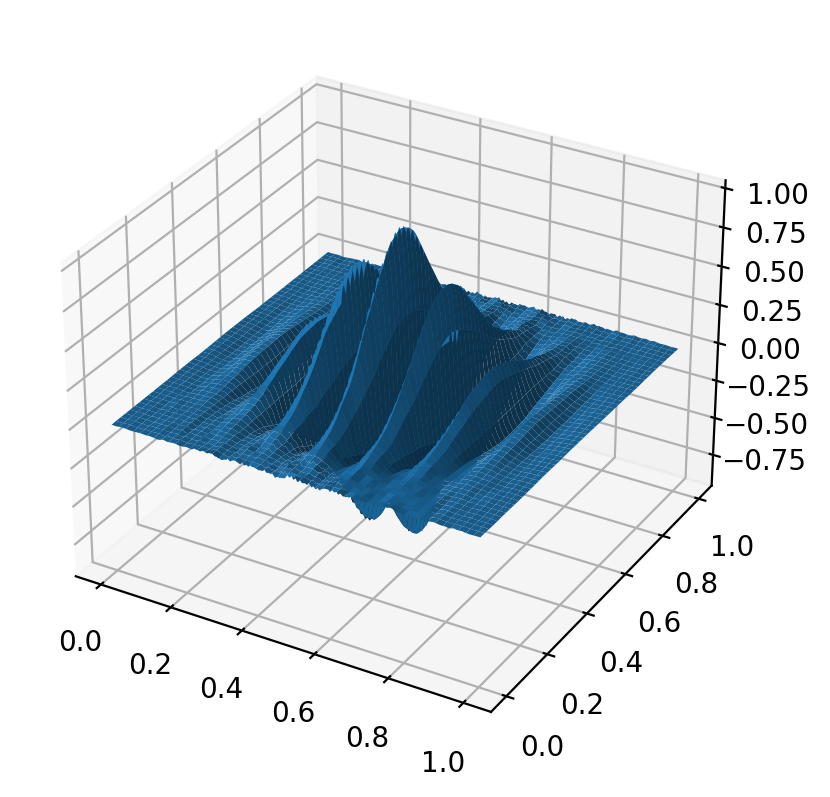

time taken:  79.55192923545837
neuron num 		 error 		 order
4		tensor(0.18754367)		*
8		tensor(0.16451488)		tensor(0.18900847)
16		tensor(0.14522769)		tensor(0.17990156)
32		tensor(0.12550798)		tensor(0.21053739)
64		tensor(0.05945584)		tensor(1.07788877)
128		tensor(0.02393172)		tensor(1.31289431)
256		tensor(0.00964766)		tensor(1.31067290)
512		tensor(0.00295331)		tensor(1.70784698)


In [12]:


def target(x):
    sigma = 0.15# s.d of Gaussian 
    frequency = 8  # frequency of cosine 
    z=  torch.exp( - ( (x[:,0:1]-0.5)**2 + ( x[:,1:2] -0.5)**2)  / (2*sigma**2)) *  torch.cos(2 * pi * frequency * x[:,0:1])
    return z 

exponent = 9 
num_epochs= 2**exponent
plot_freq = 2**exponent
Nx = 50 
order = 3 
err_list = [] 
for num in [[6,6],[6,7],[7,7],[7,8]]:  # 
    my_model = None 
    relu_dict_parameters = generate_relu_dict2D(2**num[0],2**num[1]).to(device)
    err, my_model = OGAL2FittingReLU2D(my_model,target,relu_dict_parameters,
                            num_epochs,plot_freq, Nx, order, k =1, linear_solver = "direct")

    err_list.append(err)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    errs = [err[i] for i in neuron_nums ]
    
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(errs):
        if i == 0: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t")
            print("*")
        else: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t") 
            print(np.log(errs[i-1]/errs[i])/np.log(2))


In [13]:
# torch.save(err_list, "2DGabor_err_list.pt")

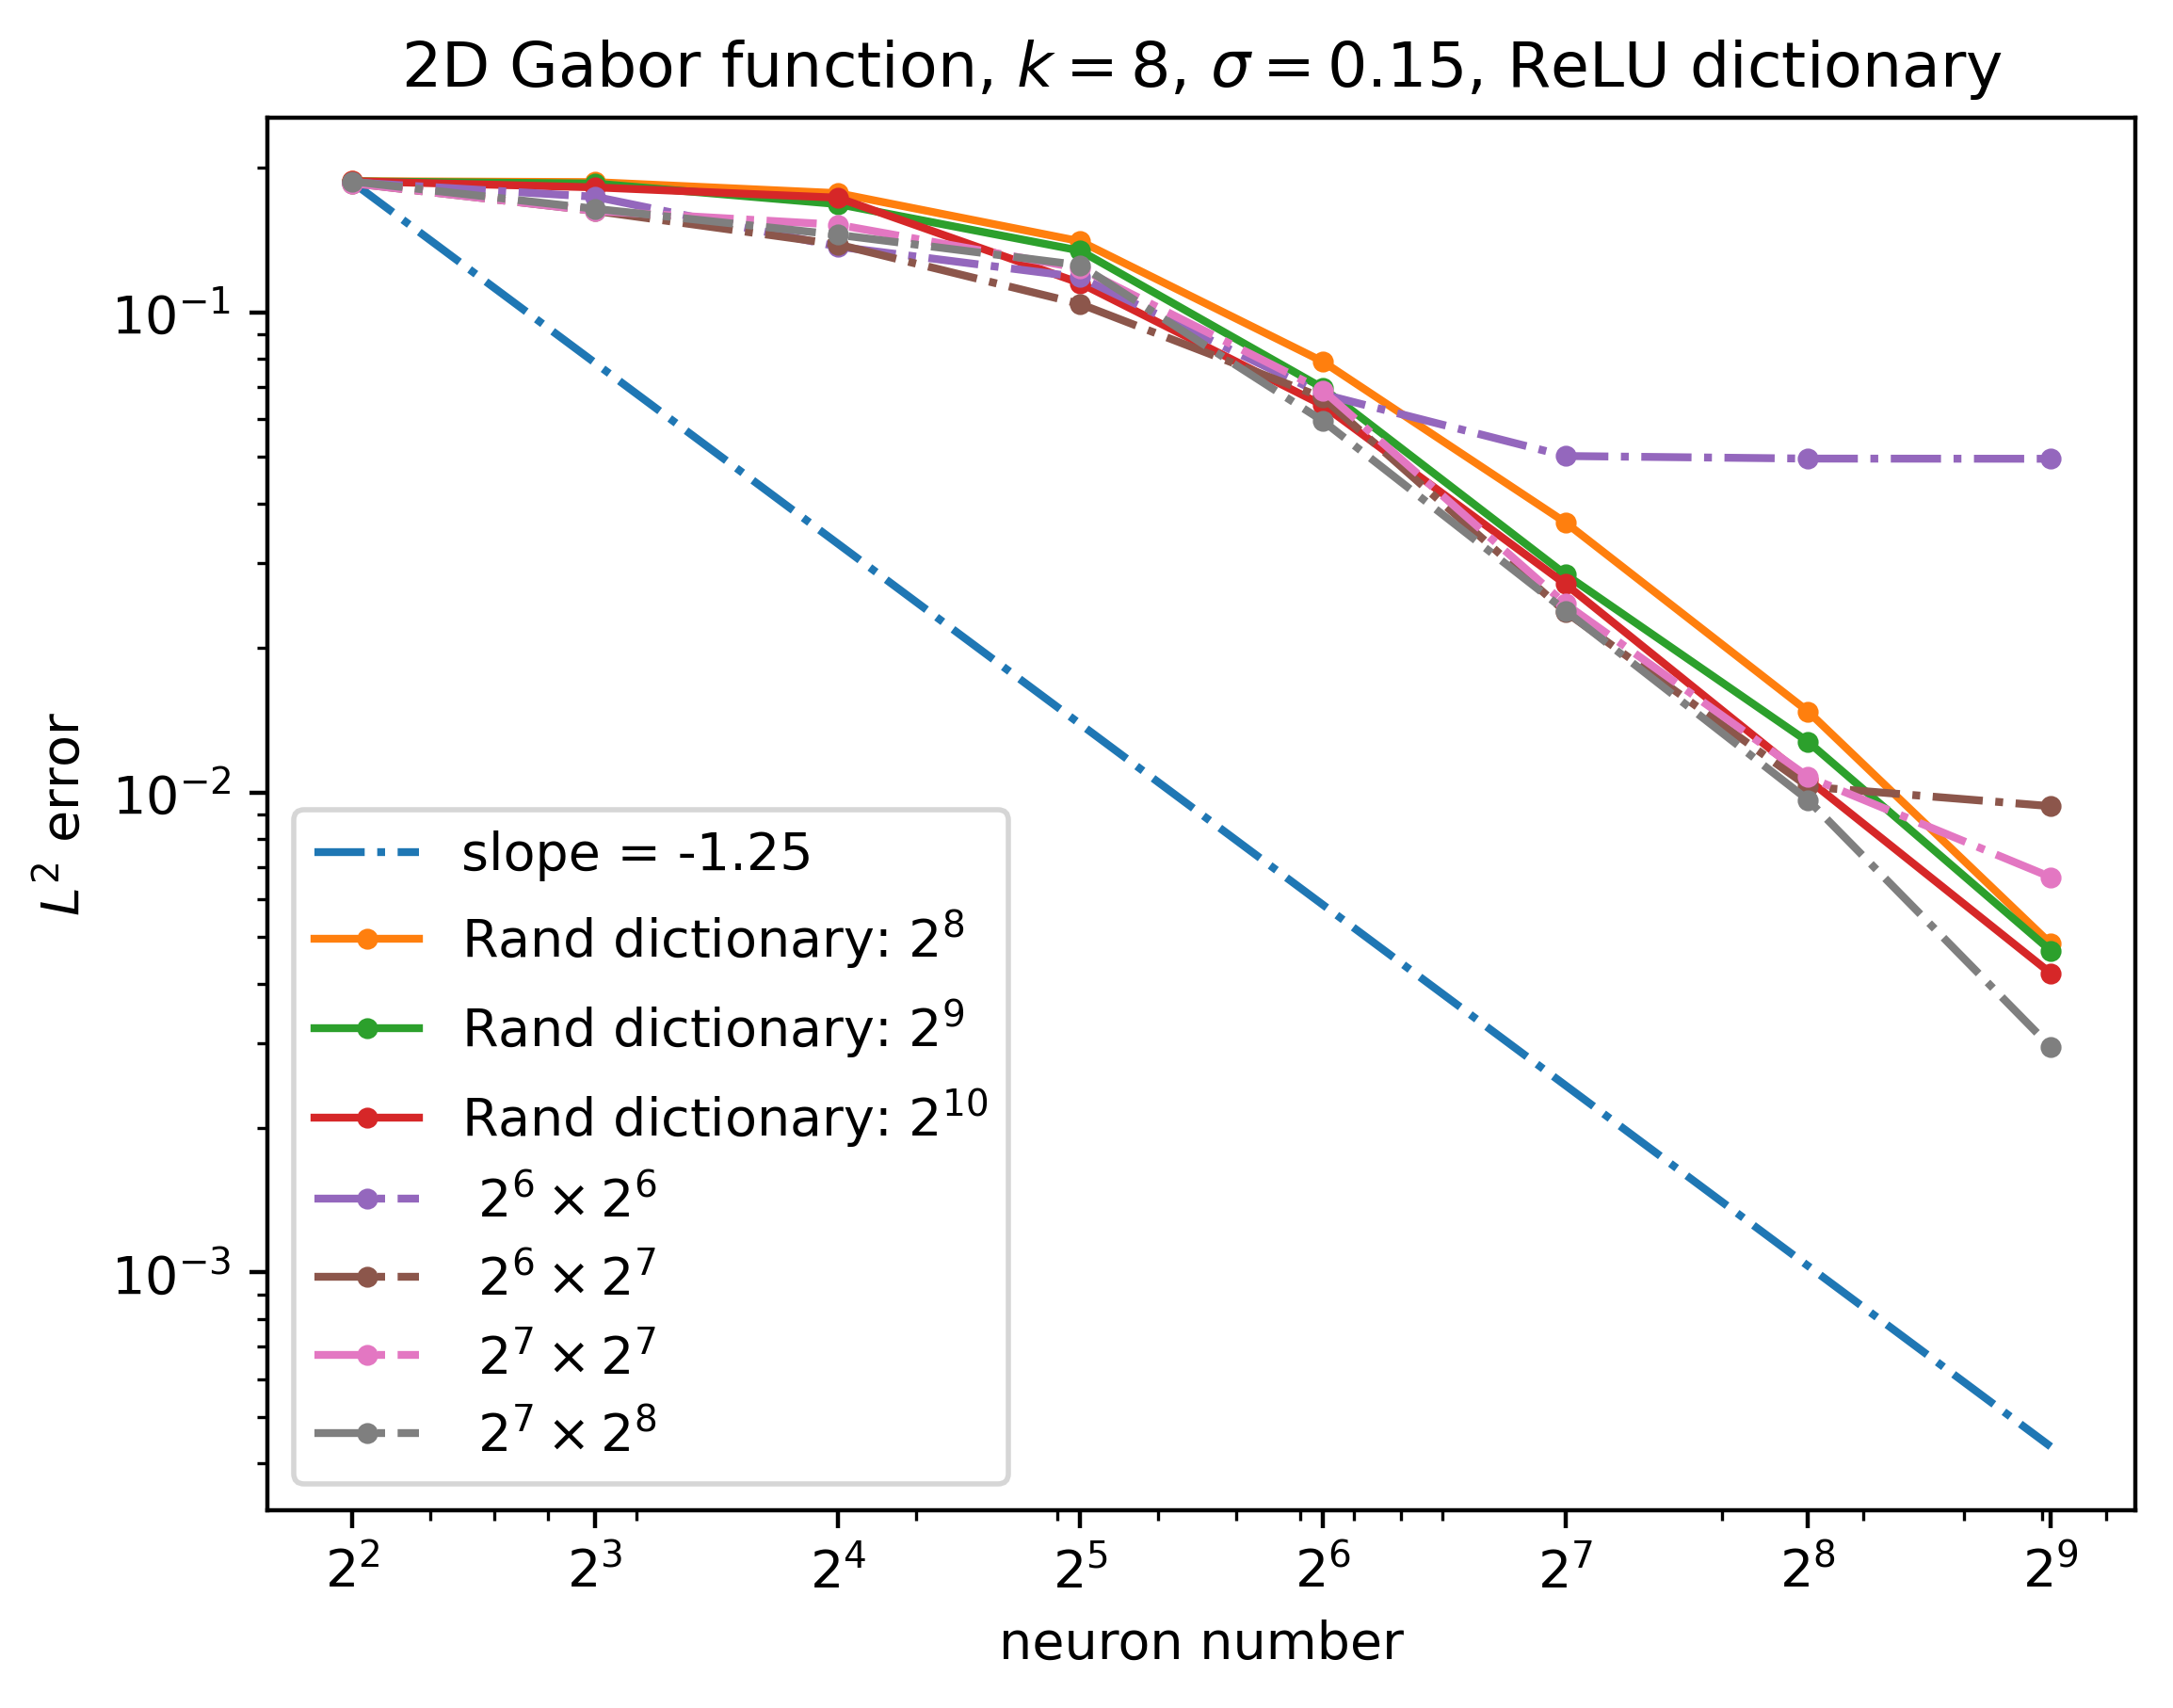

In [56]:
err_list_deterministic = torch.load("2DGabor_err_list_deterministic.pt")


exponent = 9 
neuron_nums = np.array([2**j for j in range(2,exponent+1)]) 
err_qmc = [0.18798549,0.18514664,0.17453844 ,0.12222007,0.07127362,0.03076002,0.01082704,0.00424251] 

dictionary_size_exponent_random = [8,9,10]
dictionary_size = [[6,6],[6,7],[7,7],[7,8]]
plt.figure(dpi = 400)

x = np.array(range(4, 2**exponent+1))

ref = err_list_deterministic[0][2**2]* (x/ 4)**(-1.25)
plt.plot(x,ref,'-.',label = 'slope = -1.25')

for i, err in enumerate(err_list_random): 
    plt.plot(neuron_nums, err[neuron_nums],'.-',label = "Rand dictionary: $2^{{{}}}$".format(dictionary_size_exponent_random[i]))

# plt.plot(neuron_nums, err_qmc,'.-',label = "Rand dictionary: $2^{10}$")

for i, err in enumerate(err_list_deterministic): 
    plt.plot(neuron_nums, err[neuron_nums],'.-.', 
             label = " $2^{} \\times 2^{}$ ".format(dictionary_size[i][0],dictionary_size[i][1] ))
plt.title("2D Gabor function, $k = 8$, $\sigma=0.15$, ReLU dictionary")
plt.yscale('log')
plt.xscale('log')
# plt.grid("True")
plt.xlabel("neuron number")
plt.ylabel("$L^2$ error")
plt.xticks(neuron_nums,[rf"$2^{{{ns}}}$" for ns in range(2,10)])
plt.legend()    
plt.show()

### Gaussian function 2D 

In [6]:
my_model = None 
def target(x):
    sigma = 0.1# s.d of Gaussian 
    frequency = 8  # frequency of cosine 
    z=  torch.exp( - ( (x[:,0:1]-0.5)**2 + ( x[:,1:2] -0.5)**2)  / (2*sigma**2))  # *  torch.cos(2 * pi * frequency * x[:,0:1])
    return z 

function_name = "2DGaussian"
# plot_2D(target)
exponent = 9 
num_epochs=  2**exponent 
plot_freq = 2**exponent+1 
err_list_random = [] 

for s in [2**2, 2**3,2**4]: 
    my_model = None 
    N0 = 2**6 
    Nx = 50 
    order = 3 
    err, my_model = OGAL2FittingReLU2D_QMC(my_model,target,s,N0,num_epochs,plot_freq, Nx, order, k =1, linear_solver = "direct")
    err_list_random.append(err)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err[i] for i in neuron_nums ]
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t")
            print("*")
        else: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t") 
            print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            
torch.save(err_list_random, "2D_{}_err_list_random.pt".format(function_name))


using linear solver:  direct
epoch:  1	epoch:  2	epoch:  3	epoch:  4	epoch:  5	epoch:  6	epoch:  7	epoch:  8	epoch:  9	epoch:  10	epoch:  11	epoch:  12	epoch:  13	epoch:  14	epoch:  15	epoch:  16	epoch:  17	epoch:  18	epoch:  19	epoch:  20	epoch:  21	epoch:  22	epoch:  23	epoch:  24	epoch:  25	epoch:  26	epoch:  27	epoch:  28	epoch:  29	epoch:  30	epoch:  31	epoch:  32	epoch:  33	epoch:  34	epoch:  35	epoch:  36	epoch:  37	epoch:  38	epoch:  39	epoch:  40	epoch:  41	epoch:  42	epoch:  43	epoch:  44	epoch:  45	epoch:  46	epoch:  47	epoch:  48	epoch:  49	epoch:  50	epoch:  51	epoch:  52	epoch:  53	epoch:  54	epoch:  55	epoch:  56	epoch:  57	epoch:  58	epoch:  59	epoch:  60	epoch:  61	epoch:  62	epoch:  63	epoch:  64	epoch:  65	epoch:  66	epoch:  67	epoch:  68	epoch:  69	epoch:  70	epoch:  71	epoch:  72	epoch:  73	epoch:  74	epoch:  75	epoch:  76	epoch:  77	epoch:  78	epoch:  79	epoch:  80	epoch:  81	epoch:  82	epoch:  83	epoch:  84	epoch:  85	epoch:  86	epoch:  87	epoch:  88	epoch:  89	e

In [ ]:

function_name = "2DGaussian"

def target(x):
    sigma = 0.1# s.d of Gaussian 
    z=  torch.exp( - ( (x[:,0:1]-0.5)**2 + ( x[:,1:2] -0.5)**2)  / (2*sigma**2))  # *  torch.cos(2 * pi * frequency * x[:,0:1])
    return z 

exponent = 9 
num_epochs= 2**exponent
plot_freq = 2**exponent
Nx = 50 
order = 3 
err_list = [] 
for num in [[6,6],[6,7],[7,7],[7,8]]:  # 
    my_model = None 
    err, my_model = OGAL2FittingReLU2D(my_model,target,N_list,
                            num_epochs,plot_freq, Nx, order, k =1, linear_solver = "direct")

    err_list_deterministic.append(err)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    errs = [err[i] for i in neuron_nums ]
    
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(errs):
        if i == 0: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t")
            print("*")
        else: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t") 
            print(np.log(errs[i-1]/errs[i])/np.log(2))

torch.save(err_list_deterministic, "2D_{}_err_list_deterministic.pt".format(function_name))


In [20]:
import os
import json

cuda_alloc_conf = os.environ.get('PYTORCH_CUDA_ALLOC_CONF')
if cuda_alloc_conf:
    cuda_alloc_conf = json.loads(cuda_alloc_conf)
    max_split_size_mb = cuda_alloc_conf.get('max_split_size_mb')
    print(f"Current max_split_size_mb: {max_split_size_mb} MB")
else:
    print("PYTORCH_CUDA_ALLOC_CONF environment variable not set.")

Current max_split_size_mb: 2048 MB


In [7]:
neuron_nums = [2**j for j in range(2,9)]
err_list = [err[i] for i in neuron_nums ]

print("neuron num \t\t error \t\t order")
for i, item in enumerate(err_list):
    if i == 0: 
        print(neuron_nums[i], end = "\t\t")
        print(item, end = "\t\t")
        print("*")
    else: 
        print(neuron_nums[i], end = "\t\t")
        print(item, end = "\t\t") 
        print(np.log(err_list[i-1]/err_list[i])/np.log(2))

neuron num 		 error 		 order
4		tensor(0.18657228)		*
8		tensor(0.16087906)		tensor(0.21375813)
16		tensor(0.13855207)		tensor(0.21554824)
32		tensor(0.12435550)		tensor(0.15595799)
64		tensor(0.06713362)		tensor(0.88936288)
128		tensor(0.02542356)		tensor(1.40086969)
256		tensor(0.01910289)		tensor(0.41237462)


In [7]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Print the CUDA version
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("CUDA is not available on this system.")

CUDA version: 11.7


In [2]:
import subprocess

# Run the 'nvidia-smi' command and capture the output
result = subprocess.run(['nvidia-smi', '--query-gpu=memory.total', '--format=csv,noheader,nounits'], stdout=subprocess.PIPE, text=True)

# Get the GPU memory total from the output
gpu_memory = int(result.stdout.strip())

# Print the GPU memory in gigabytes (GB)
print(f"GPU memory: {gpu_memory} MB")

GPU memory: 32768 MB


In [1]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the name of the GPU device
    gpu_name = torch.cuda.get_device_name(0)  # Assuming you have one GPU (device index 0)

    # Check if the GPU is an A100
    is_a100 = "A100" in gpu_name

    if is_a100:
        print(f"The GPU is an A100: {gpu_name}")
    else:
        print(f"The GPU is not an A100: {gpu_name}")
else:
    print("CUDA is not available on this system.")


The GPU is an A100: NVIDIA A100-SXM4-80GB
